In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [131]:
dir.create("pipeline/eqtl.2.1.genomewide_significant_loci"     , showWarnings = FALSE)
dir.create("pipeline/eqtl.2.1.genomewide_significant_loci/loci", showWarnings = FALSE)


In [132]:
manifest = add_rownames(fread("pipeline/1.1.sumstats/manifest.txt", sep = "\t", header = TRUE, data.table = FALSE))


In [225]:
manifest2color = manifest[,c("id", "name")]
manifest2color = rbind(manifest2color[ grepl("biomarkers" , manifest2color$id  ) == TRUE,],
                       manifest2color[ manifest2color$id == "continuous-LDLC-both_sexes-medadj_irnt",],
                       manifest2color[ grepl("biomarkers" , manifest2color$id  ) == FALSE &  grepl("pressure" , manifest2color$name) == FALSE &  grepl("icd10" , manifest2color$id) == FALSE &  grepl("phecode" , manifest2color$id) == FALSE &  grepl("categorical" , manifest2color$id) == FALSE & manifest2color$id != "continuous-LDLC-both_sexes-medadj_irnt",],
                       manifest2color[ grepl("pressure"   , manifest2color$name) == TRUE,],
                       manifest2color[ grepl("icd10"      , manifest2color$id  ) == TRUE,],
                       manifest2color[ grepl("phecode"    , manifest2color$id  ) == TRUE,],
                       manifest2color[ grepl("categorical", manifest2color$id  ) == TRUE,]
                      )
manifest2color$category = c(rep("Biomarkers", 7), rep ("Heart rate", 3), rep("General", 2), rep("Pressure", 4), rep("Disease", 7), rep("Drugs", 4))
manifest2color$color    = c(sequential_hcl(n = 7, palette = "Mako"),
                            sequential_hcl(n = 3, palette = "Burg"),
                            sequential_hcl(n = 2, palette = "Batlow"),
                            sequential_hcl(n = 4, palette = "YlOrBr"),
                            sequential_hcl(n = 7, palette = "SunsetDark"),
                            sequential_hcl(n = 4, palette = "YlGnBu")
                           )

manifest2color$order = 1:nrow(manifest2color)

fwrite(manifest2color, "pipeline/eqtl.2.1.genomewide_significant_loci/manifest2color.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


# Find genome wide-significant loci

In [422]:
totest = manifest$id[1:2]


In [429]:
get_loci = function(id, manifest, populations)
{
    message(id, appendLF = FALSE)
    
    infile        = manifest[id, "sumstat_file"]
    indata        = fread(cmd = paste("zcat", infile), sep = "\t", header = TRUE, data.table = FALSE)
    out           = indata
    out           = out[ is.na(out$pval_meta) == FALSE & out$pval_meta <= 5e-8 & out$pval_heterogeneity >= 1e-6, c("chr", "pos", "ref", "alt", "pval_meta")]
    colnames(out) = c("chrom", "pos", "ref", "alt", "pval")
    out$id        = paste(out$chrom, out$pos, out$ref, out$alt, sep = "_")
    rownames(out) = out$id
    
    return(out)
}

populations     = c('AFR','AMR','CSA','EAS','EUR','MID')
var_list        = lapply(totest, function(id){get_loci(id, manifest, populations)})
names(var_list) = totest

saveRDS(var_list, "pipeline/eqtl.2.1.genomewide_significant_loci/loci/var_list.rds")


biomarkers-30600-both_sexes-irnt
biomarkers-30680-both_sexes-irnt


# Find genome wide-significant loci for each trait
- all SNPs at 10 kb distance

In [441]:
find_index_snp = function(chrom, from, to, indata)
{
    indata = indata[indata$chrom == chrom & indata$pos >= from & indata$pos <= to,]
    return(indata[which.min(indata$pval), "id"])
}

find_loci = function(id, var_list, distance = 10000)
{
    message(id, appendLF = FALSE)
    
    indata       = var_list[[id]]
    indata       = indata[ is.na(indata$pval) == FALSE,]
    to_merge_bed = paste0(getwd(), "/pipeline/eqtl.2.1.genomewide_significant_loci/loci/", id, ".bed")
    
    fwrite(indata[order(indata$chr, indata$pos), c("chrom", "pos", "pos", "id", "pval")], to_merge_bed, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    command          = paste("bedtools", "merge", "-d", distance, "-c", "4,5", "-o", "count,min", "-i", to_merge_bed)
    merged           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(merged) = c("chrom", "from", "to", "n_snps", "pval")
    merged$id        = unlist(lapply(1:nrow(merged), function(ii){find_index_snp(merged[ii, "chrom"], merged[ii, "from"], merged[ii, "to"], indata)}))
    merged$locus     = paste(merged$chrom, merged$from, merged$to, sep = "_")
    merged$distance  = c(-1, merged[2:nrow(merged), "from"] - merged[1:(nrow(merged) - 1), "to"])
    
    merged[ merged$distance < 0, "distance"] = -1

    return(merged)
}

loci_list        = lapply(totest, function(id){find_loci(id, var_list)})
names(loci_list) = totest


biomarkers-30600-both_sexes-irnt
biomarkers-30680-both_sexes-irnt


In [438]:
str(loci_list)

List of 2
 $ biomarkers-30600-both_sexes-irnt:'data.frame':	1538 obs. of  6 variables:
  ..$ chrom : int [1:1538] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ from  : int [1:1538] 1468177 9434968 11070918 11112835 16388473 16464672 16549531 16574315 16594789 16614946 ...
  ..$ to    : int [1:1538] 1516271 9454254 11094666 11326923 16453217 16536549 16563636 16582687 16603637 16640073 ...
  ..$ n_snps: int [1:1538] 63 49 27 171 91 125 5 2 3 7 ...
  ..$ pval  : num [1:1538] 6.32e-16 7.08e-14 9.26e-10 2.77e-11 1.58e-13 ...
  ..$ id    : chr [1:1538] "1_1481348_T_C" "1_9451253_G_A" "1_11070919_T_G" "1_11128329_A_G" ...
 $ biomarkers-30680-both_sexes-irnt:'data.frame':	1506 obs. of  6 variables:
  ..$ chrom : int [1:1506] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ from  : int [1:1506] 1065799 16426654 16467390 16549531 16574315 16594789 16614946 16651579 16691021 16709433 ...
  ..$ to    : int [1:1506] 1103151 16433307 16528601 16563636 16582687 16603637 16640073 16668372 16694775 16716375 ...
  ..$ n_snps: int [1:150

In [440]:
x = var_list[[1]]

x["1_9451253_G_A",]

chrom pos     ref alt pval      id           
1_9451253_G_A 1     9451253 G   A   7.084e-14 1_9451253_G_A

In [ ]:

merge_all_loci = function(loci_list, distance)
{
    to_merge = as.data.frame(rbindlist(lapply(names(loci_list), function(trait)
    {
        x        = loci_list[[trait]][,c("chrom", "from", "to")]
        x$trait  = trait
        return(x)
    })), stringsAsFactors = FALSE)
    
    to_merge     = to_merge[order(to_merge$chrom, to_merge$from, to_merge$to),]
    to_merge_bed = "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_unmerged.bed"
    merged_bed   = "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_merged.bed"
    
    fwrite(to_merge, to_merge_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

    command          = paste("bedtools", "merge", "-d", distance, "-c", "4,4,4", "-o", "count,count_distinct,distinct", "-i", to_merge_bed)
    merged           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(merged) = c("chrom", "from", "to", "loci_n", "traits_n", "traits")
    merged$distance  = c(-1, merged[2:nrow(merged), "from"] - merged[1:(nrow(merged) - 1), "to"])
    merged$locus     = paste(merged$chrom, merged$from, merged$to, sep = "_")
    merged$size      = merged$to - merged$from
    merged           = merged[order(merged$chrom, merged$from, merged$to),]
    
    merged[ merged$distance < 0, "distance"] = -1
    
    fwrite(merged[,c("chrom", "from", "to", "locus")], merged_bed, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    trait2locus = as.data.frame(rbindlist(lapply(names(loci_list), function(trait)
    {
        trait_bed     = paste0("pipeline/eqtl.2.1.genomewide_significant_loci/loci/", trait, ".merged.bed")
        command       = paste("bedtools", "intersect", "-loj", "-a", trait_bed, "-b", merged_bed)
        out           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)[,c(1:5,9)]
        colnames(out) = c("chrom", "from", "to", "locus_trait", "pval", "locus")
        out$trait     = trait
        
        return(out)
    })), stringsAsFactors = FALSE)
    
    return(list(loci = merged, trait2locus = trait2locus))
}

#totest           = manifest$id[1:2]
loci_merged      = merge_all_loci(loci_list)

saveRDS(loci_merged, "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_merged_list.rds")


# OLD

In [277]:
find_loci = function(id, var_list, distance = 10000)
{
    message(id, appendLF = FALSE)
    
    indata       = var_list[[id]]
    indata       = indata[ is.na(indata$pval) == FALSE,]
    indata$id    = id
    to_merge_bed = paste0("pipeline/eqtl.2.1.genomewide_significant_loci/loci/", id, ".unmerged.bed")
    merged_bed   = paste0("pipeline/eqtl.2.1.genomewide_significant_loci/loci/", id, ".merged.bed"  )
    
    fwrite(indata[order(indata$chr, indata$pos), c("chrom", "pos", "pos", "id", "pval")], to_merge_bed, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    command          = paste("bedtools", "merge", "-d", distance, "-c", "4,5", "-o", "count,min", "-i", to_merge_bed)
    merged           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(merged) = c("chrom", "from", "to", "n_snps", "pval")
    merged$locus     = paste(merged$chrom, merged$from, merged$to, sep = "_")
    merged$distance  = c(-1, merged[2:nrow(merged), "from"] - merged[1:(nrow(merged) - 1), "to"])
    
    merged[ merged$distance < 0, "distance"] = -1

    fwrite(merged[,c("chrom", "from", "to", "locus", "pval")], merged_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

    return(merged)
}

merge_all_loci = function(loci_list)
{
    to_merge = as.data.frame(rbindlist(lapply(names(loci_list), function(trait)
    {
        x        = loci_list[[trait]][,c("chrom", "from", "to")]
        x$trait  = trait
        return(x)
    })), stringsAsFactors = FALSE)
    
    to_merge     = to_merge[order(to_merge$chrom, to_merge$from, to_merge$to),]
    to_merge_bed = "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_unmerged.bed"
    merged_bed   = "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_merged.bed"
    
    fwrite(to_merge, to_merge_bed, sep = "\t", col.names = FALSE, row.names = FALSE)

    command          = paste("bedtools", "merge", "-d", 50000, "-c", "4,4,4", "-o", "count,count_distinct,distinct", "-i", to_merge_bed)
    merged           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(merged) = c("chrom", "from", "to", "loci_n", "traits_n", "traits")
    merged$distance  = c(-1, merged[2:nrow(merged), "from"] - merged[1:(nrow(merged) - 1), "to"])
    merged$locus     = paste(merged$chrom, merged$from, merged$to, sep = "_")
    merged$size      = merged$to - merged$from
    merged           = merged[order(merged$chrom, merged$from, merged$to),]
    
    merged[ merged$distance < 0, "distance"] = -1
    
    fwrite(merged[,c("chrom", "from", "to", "locus")], merged_bed, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    trait2locus = as.data.frame(rbindlist(lapply(names(loci_list), function(trait)
    {
        trait_bed     = paste0("pipeline/eqtl.2.1.genomewide_significant_loci/loci/", trait, ".merged.bed")
        command       = paste("bedtools", "intersect", "-loj", "-a", trait_bed, "-b", merged_bed)
        out           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)[,c(1:5,9)]
        colnames(out) = c("chrom", "from", "to", "locus_trait", "pval", "locus")
        out$trait     = trait
        
        return(out)
    })), stringsAsFactors = FALSE)
    
    return(list(loci = merged, trait2locus = trait2locus))
}

#totest           = manifest$id[1:2]
loci_list        = lapply(totest, function(id){find_loci(id, var_list)})
names(loci_list) = totest
loci_merged      = merge_all_loci(loci_list)

saveRDS(loci_merged, "pipeline/eqtl.2.1.genomewide_significant_loci/loci/loci_merged_list.rds")


biomarkers-30600-both_sexes-irnt
biomarkers-30680-both_sexes-irnt
biomarkers-30690-both_sexes-irnt
biomarkers-30760-both_sexes-irnt
biomarkers-30780-both_sexes-irnt
biomarkers-30870-both_sexes-irnt
categorical-20003-both_sexes-1140861958
categorical-20003-both_sexes-1140866738
categorical-20003-both_sexes-1140879802
categorical-20003-both_sexes-1141146234
continuous-102-both_sexes-irnt
continuous-12336-both_sexes-irnt
continuous-12340-both_sexes-irnt
continuous-20022-both_sexes-irnt
continuous-21001-both_sexes-irnt
continuous-DBP-both_sexes-combined_medadj_irnt
continuous-LDLC-both_sexes-medadj_irnt
continuous-MAP-both_sexes-combined_medadj_irnt
continuous-PP-both_sexes-combined_medadj_irnt
continuous-SBP-both_sexes-combined_medadj_irnt
icd10-I20-both_sexes
icd10-I25-both_sexes
icd10-I26-both_sexes
icd10-I48-both_sexes
phecode-401-both_sexes
phecode-411.2-both_sexes
phecode-411.4-both_sexes


In [278]:
str(loci_list[1:2])

str(loci_merged)

List of 2
 $ biomarkers-30600-both_sexes-irnt:'data.frame':	588 obs. of  7 variables:
  ..$ chrom   : int [1:588] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ from    : int [1:588] 1468177 9434968 11070918 16388473 23720184 25291697 25561666 33441358 39551487 59622218 ...
  ..$ to      : int [1:588] 1516271 9454254 11326923 16731511 23811489 25291697 25863695 33441358 40089596 59643857 ...
  ..$ n_snps  : int [1:588] 63 49 198 244 23 1 203 1 360 4 ...
  ..$ pval    : num [1:588] 6.32e-16 7.08e-14 2.77e-11 1.02e-34 6.83e-11 ...
  ..$ locus   : chr [1:588] "1_1468177_1516271" "1_9434968_9454254" "1_11070918_11326923" "1_16388473_16731511" ...
  ..$ distance: num [1:588] -1 7918697 1616664 5061550 6988673 ...
 $ biomarkers-30680-both_sexes-irnt:'data.frame':	507 obs. of  7 variables:
  ..$ chrom   : int [1:507] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ from    : int [1:507] 1065799 16426654 21573599 21759019 23718323 39576620 39995073 43208560 43367642 49206053 ...
  ..$ to      : int [1:507] 1103151 16731511 21685

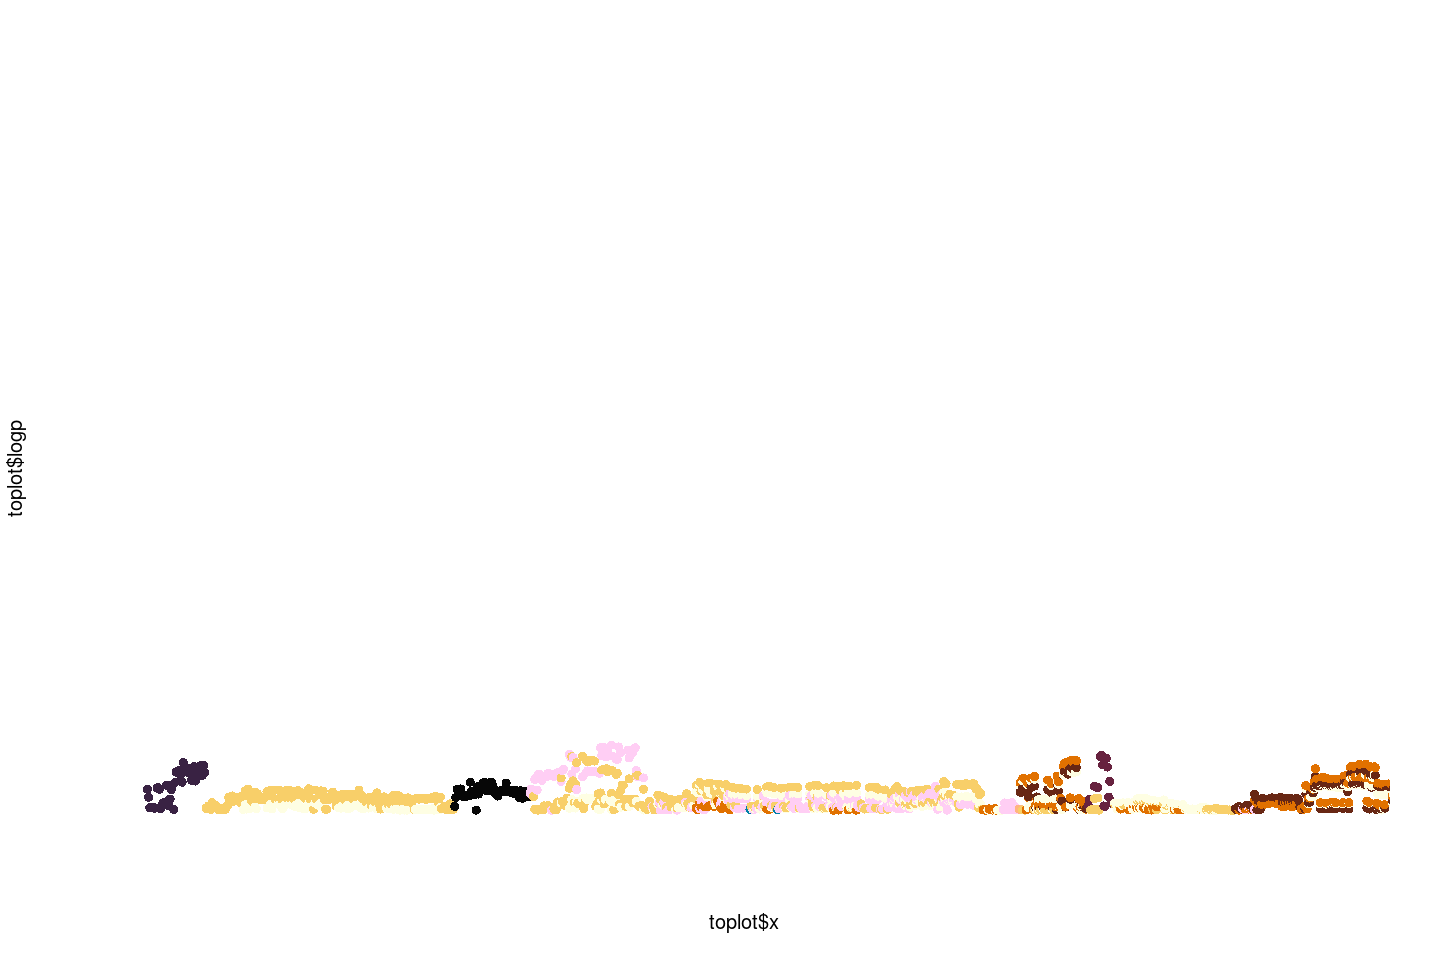

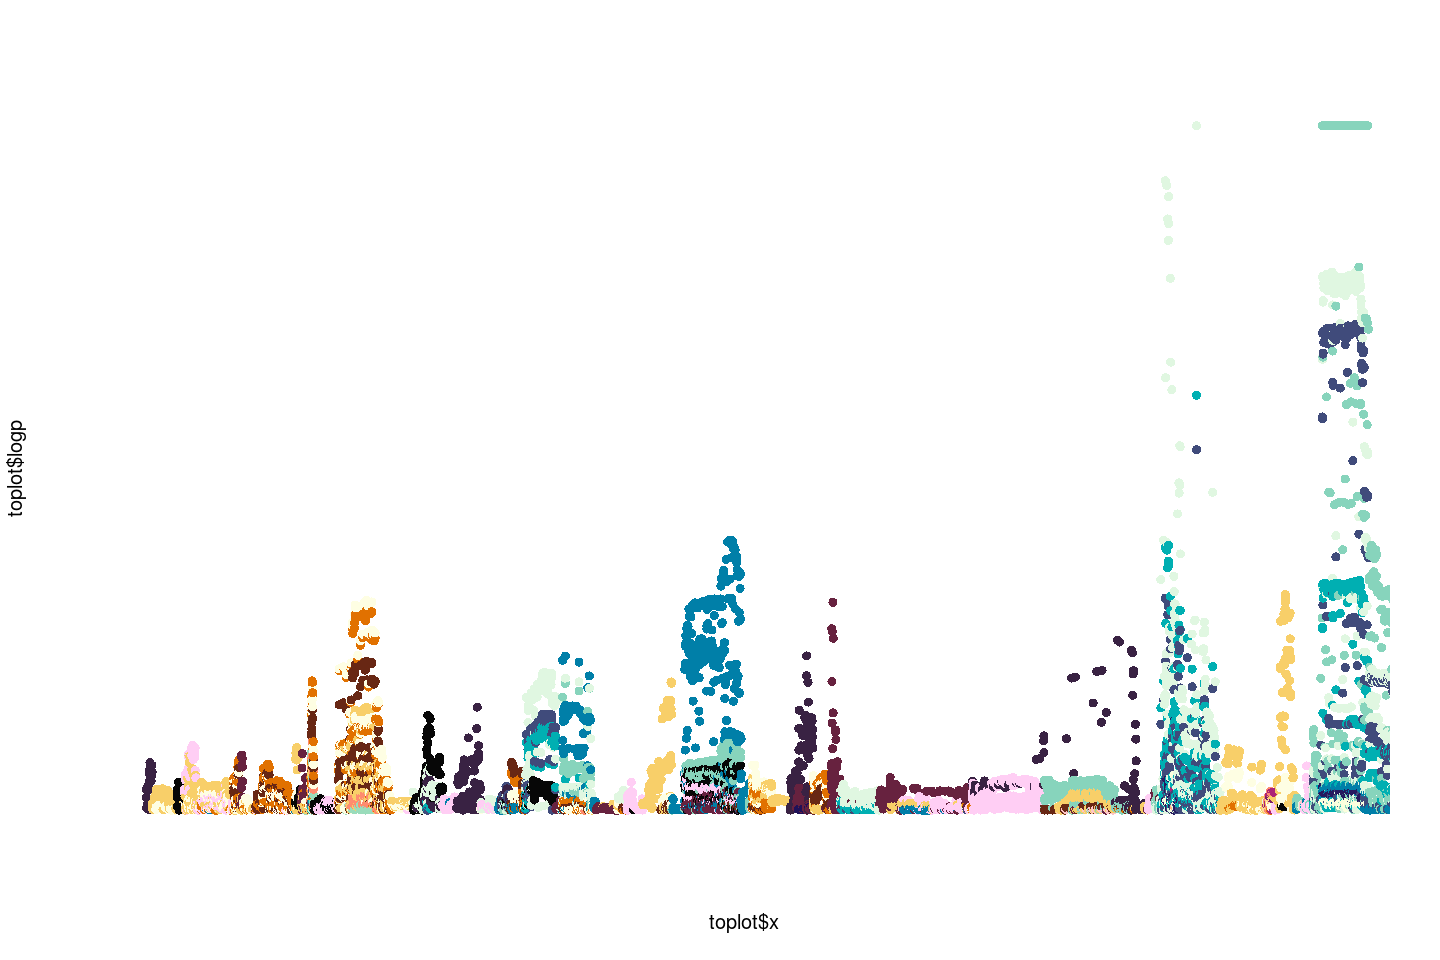

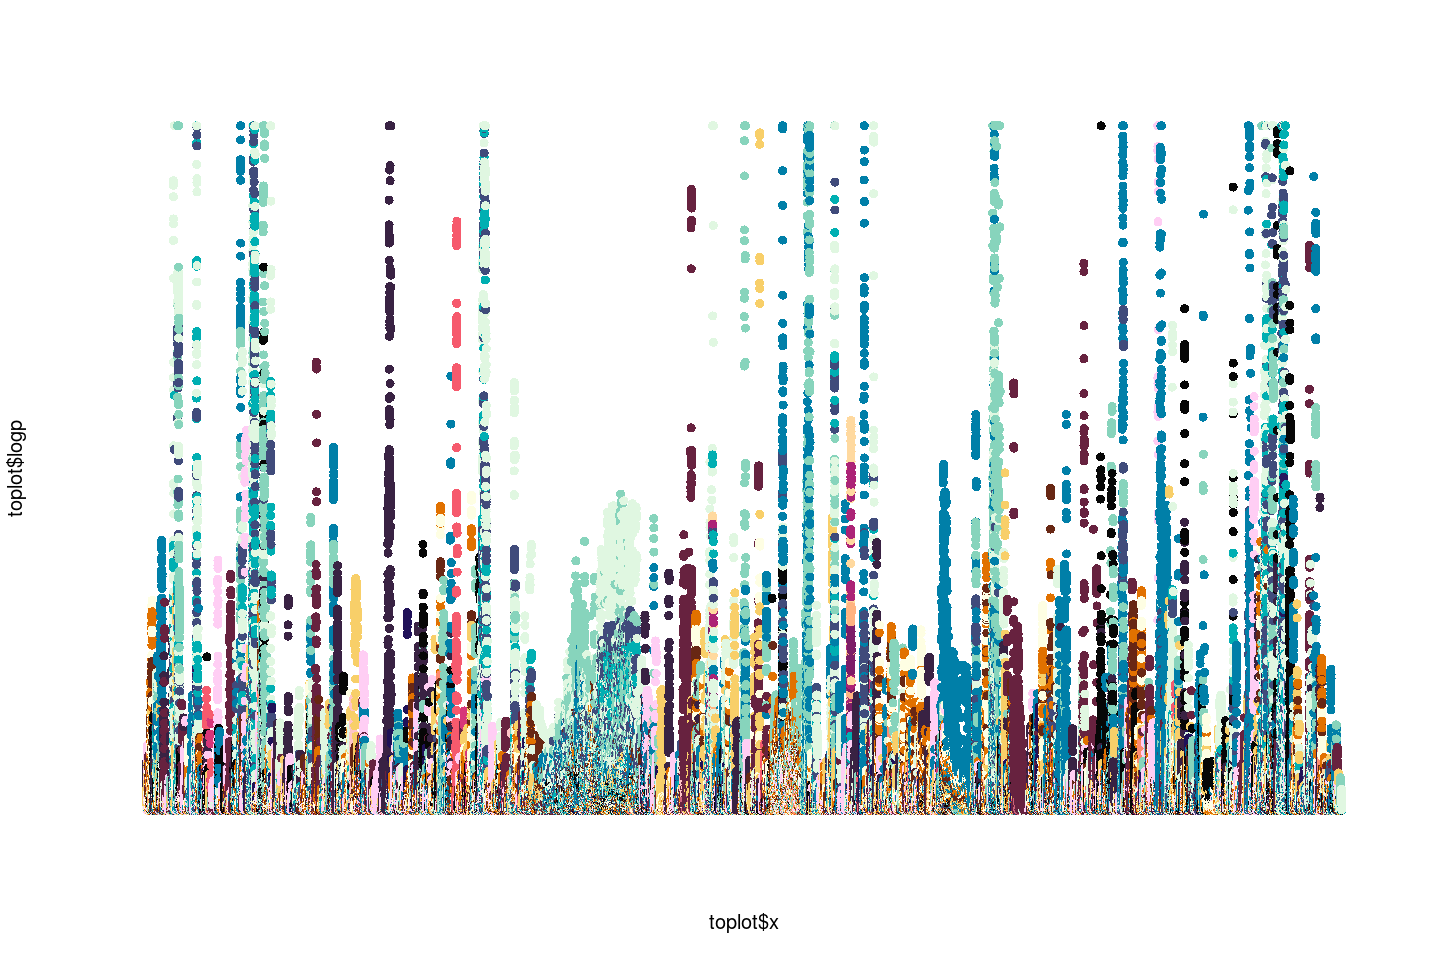

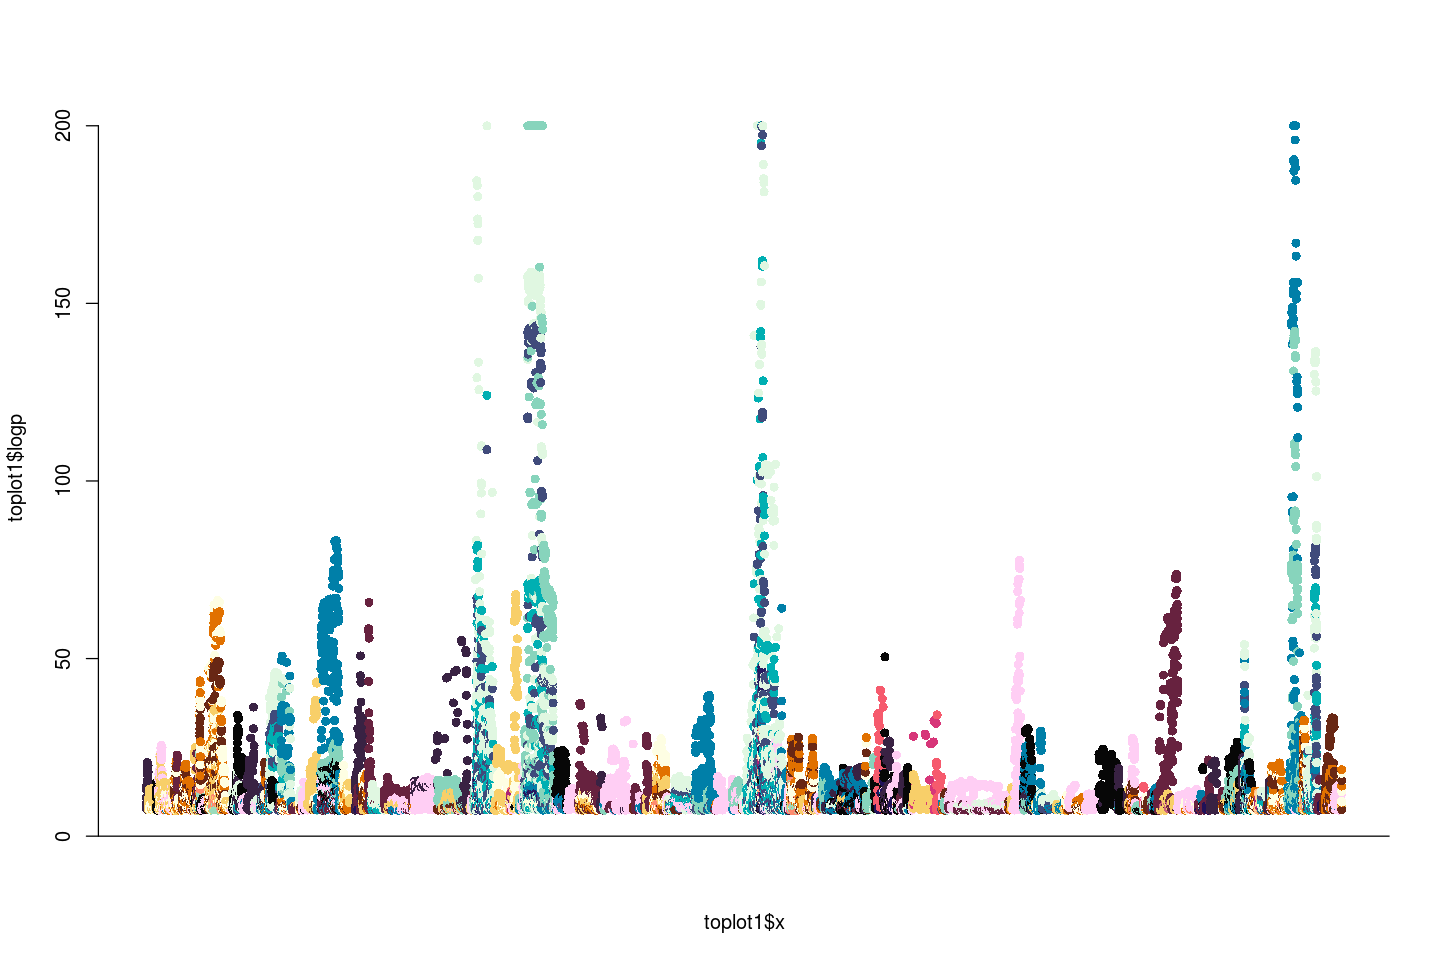

In [415]:
plot_manhattan = function(manifest2color, loci_merged, var_list)
{
    toplot = as.data.frame(rbindlist(lapply(manifest2color$id, function(trait)
    {
        x       = var_list[[trait]]
        x       = x[is.na(x$pval) == FALSE,]
        x$id    = trait
        x$color = manifest2color[trait, "color"]
        
        return(x)
    })), stringsAsFactors = FALSE)
    
    toplot[ toplot$pval < 1e-200, "pval"] = 1e-200
    
    toplot$logp = -log10(toplot$pval)
    mypos       = unique(toplot[order(toplot$chrom, toplot$pos), c("chrom", "pos")])
    mypos$x     = 1:nrow(mypos)
    toplot      = merge(toplot, mypos, by = c("chrom", "pos"))
    toplot      = toplot[order(toplot$x, toplot$logp),]
    
    plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE, xlim = c(0,1000))
    plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE, xlim = c(0,10000))
    plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE)
    
    toplot1 = toplot[toplot$chrom == 1,]
    
    plot(toplot1$x, toplot1$logp, pch = 16, col = toplot1$color, axes = FALSE)
    axis(2)
    abline(h = 0)

    return(toplot)
}

options(repr.plot.width = 12, repr.plot.height = 8)
toplot = plot_manhattan(manifest2color, loci_merged, var_list)


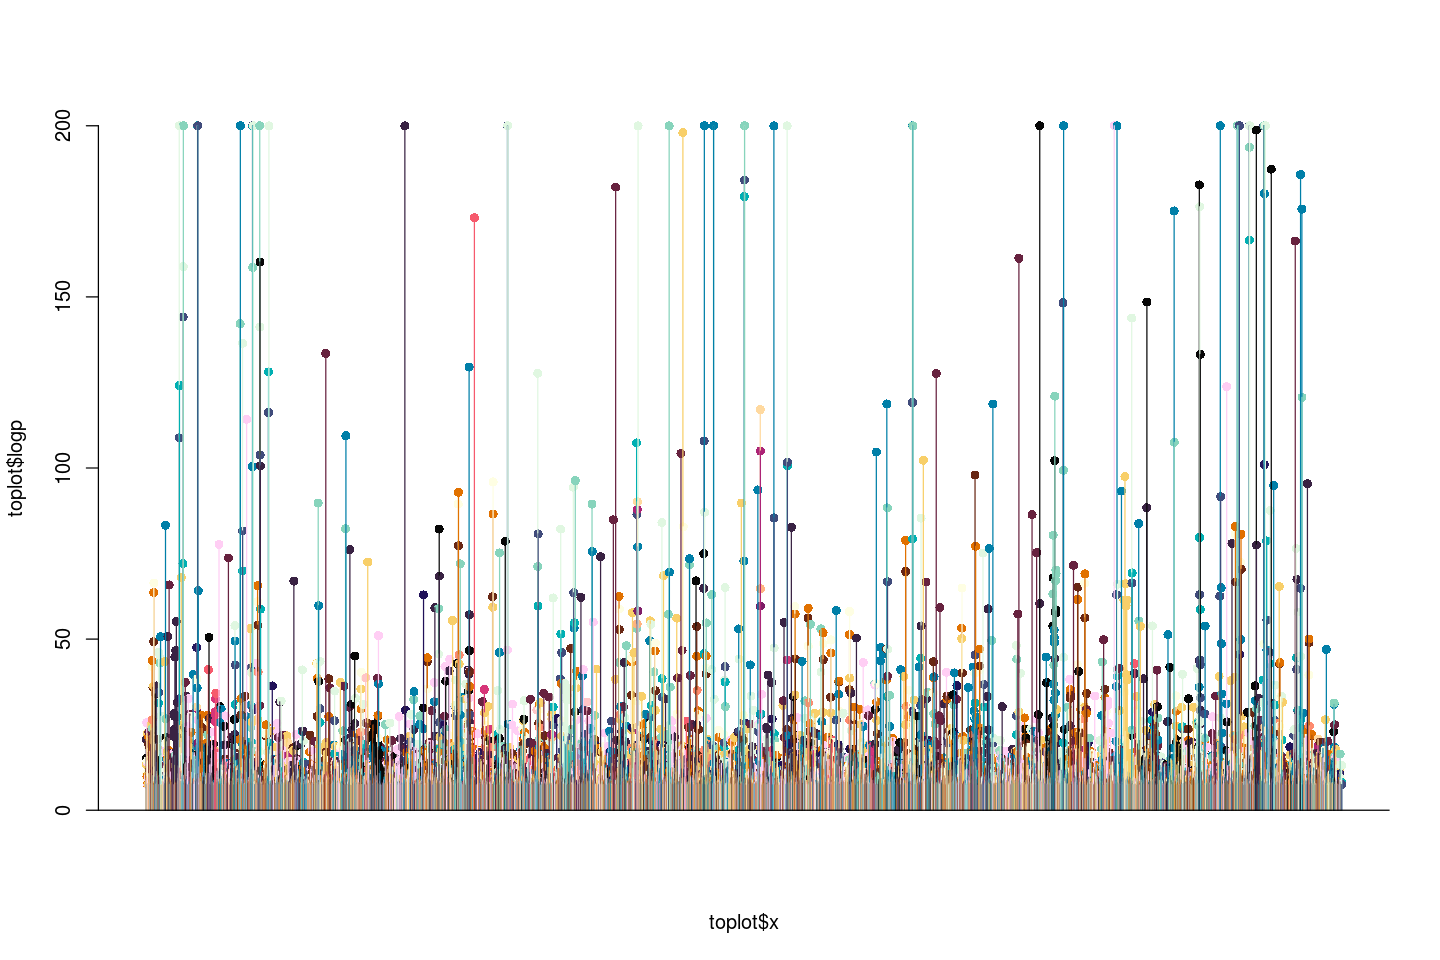

In [284]:
plot_manhattan_by_locus = function(manifest2color, loci_merged, var_list)
{
    toplot     = merge(loci_merged$trait2locus, manifest2color, by.x = "trait", by.y = "id")
    toplot$pos = rowMeans(toplot[,c("from", "to")])
    
    toplot[ toplot$pval < 1e-200, "pval"] = 1e-200
    
    toplot$logp = -log10(toplot$pval)
    mypos       = unique(toplot[order(toplot$chrom, toplot$pos), c("chrom", "pos")])
    mypos$x     = 1:nrow(mypos)
    toplot      = merge(toplot, mypos, by = c("chrom", "pos"))
    toplot      = toplot[order(toplot$x, toplot$logp),]
    
    plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE, ylim = c(0, 200))
    segments(x0 = toplot$x, y0 = 0, y1 = toplot$logp, col = toplot$color)
    axis(2)
    abline(h = 0)

    return(toplot)
}

options(repr.plot.width = 12, repr.plot.height = 8)
toplot = plot_manhattan_by_locus(manifest2color, loci_merged, var_list)




# OLD

# Find all the SNPs to test
- tests similar to panels C and D in https://link.springer.com/article/10.1186/s13040-021-00267-6#Tab1

In [293]:
trait2locus_trait = unique(merge(loci_merged$loci[,c("chrom", "from", "to", "locus")], loci_merged$trait2locus[, c("locus", "trait")], by = "locus"))

In [407]:
get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))[,1:9]
    colnames(gwas_data)  = my_head[1:9]
    gwas_data            = gwas_data[ gwas_data$pval_heterogeneity >= 1e-6, c("chr", "pos", "ref", "alt", "pval_meta", "beta_meta")]
    return(gwas_data)
    gwas_data$pval       = gwas_data$pval_meta
    gwas_data$beta       = gwas_data$beta_meta
    gwas_data$ref        = sub("RUE", "", gwas_data$ref)
    gwas_data$alt        = sub("RUE", "", gwas_data$alt)
    gwas_data$variant_id = paste(gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$variant_id
    gwas_data$logp       = -log10(gwas_data$pval)
    
    return(gwas_data[,c("pos", "ref", "alt", "variant_id", "beta", "pval", "logp")])
}

get_snps_by_locus = function(locus, trait2locus_trait, manifest)
{
    message(locus, appendLF = FALSE)
    
    coord       = sub("_", "-", sub("_", ":", locus))
    traits      = trait2locus_trait[ trait2locus_trait$locus == locus, "trait"]
    gwas        = lapply(traits, function(trait){get_gwas_data(coord, manifest[trait, "sumstat_file"])})
    names(gwas) = traits
    
    return(gwas)
}

x = get_snps_by_locus("1_109391128_110366311", trait2locus_trait, manifest)

#totest_loci               = loci_merged$loci$locus
#snps_by_locus_list        = lapply(totest_loci, function(locus){get_snps_by_locus(locus, trait2locus_trait, manifest)})
#names(snps_by_locus_list) = totest_loci
#
#saveRDS(snps_by_locus_list, "pipeline/eqtl.2.1.genomewide_significant_loci/loci/snps_by_locus_list.rds")



1_109391128_110366311


In [408]:
str(x)

List of 15
 $ continuous-21001-both_sexes-irnt              :'data.frame':	2724 obs. of  6 variables:
  ..$ chr      : int [1:2724] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ pos      : int [1:2724] 109391129 109391662 109391961 109392715 109392837 109392853 109392901 109393302 109393437 109393647 ...
  ..$ ref      : chr [1:2724] "T" "G" "T" "A" ...
  ..$ alt      : chr [1:2724] "G" "C" "G" "C" ...
  ..$ pval_meta: num [1:2724] 0.587 0.318 0.694 0.279 0.854 ...
  ..$ beta_meta: num [1:2724] -0.005087 -0.004723 0.001479 -0.005016 -0.000482 ...
 $ phecode-411.2-both_sexes                      :'data.frame':	0 obs. of  6 variables:
  ..$ chr      : int(0) 
  ..$ pos      : int(0) 
  ..$ ref      : chr(0) 
  ..$ alt      : chr(0) 
  ..$ pval_meta: num(0) 
  ..$ beta_meta: num(0) 
 $ biomarkers-30690-both_sexes-irnt              :'data.frame':	2725 obs. of  6 variables:
  ..$ chr      : int [1:2725] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ pos      : int [1:2725] 109391129 109391662 109391961 109392715 109392837 

## Test:
-	Select the top 20 SNPs by p-value (regardless of whether they are significant or not: otherwise we would have some issues when one trait has more power than the other)
-	Calculate the overlap (Jaccard score: intersection / union)
-	Set up some threshold. In the examples I have been looking at by hand, 0.5 seems like a good threshold, but I will run all samples and then decide if it needs to be increased


In [392]:
#data.frame(locus = totest_loci, n = unlist(lapply(snps_by_locus_list, function(x){length(x)})))

In [395]:
test_pairwise_overlap = function(totest)
{
    top1    = totest[order(totest$pval1), "variant_id"][1:20]
    top2    = totest[order(totest$pval2), "variant_id"][1:20]
    overlap = length(intersect(top1, top2)) / length(union(top1, top2))
    
    return(overlap)
}

test_pairwise = function(locus, trait1, trait2, snps_by_locus_list)
{
    x1      = snps_by_locus_list[[locus]][[trait1]]
    x2      = snps_by_locus_list[[locus]][[trait2]]
    totest  = merge(x1[,c("variant_id", "pval", "logp")], x2[,c("variant_id", "pval", "logp")], by = c("variant_id"), suffixes = 1:2)
    out     = data.frame(locus = locus, trait1 = trait1, trait2 = trait2, overlap = test_pairwise_overlap(totest))
    
    return(out)
}

test_pairwise_fisher_by_locus = function(locus, trait2locus_trait, snps_by_locus_list)
{
    traits = trait2locus_trait[ trait2locus_trait$locus == locus, "trait"]
    
    if(length(traits) > 1)
    {
        pairs_to_test           = as.data.frame(t(combn(traits, 2)))
        colnames(pairs_to_test) = c("trait1", "trait2")
        tests                   = as.data.frame(rbindlist(lapply(1:nrow(pairs_to_test), function(ii)
        {
            test_pairwise(locus, pairs_to_test[ii, "trait1"], pairs_to_test[ii, "trait2"], snps_by_locus_list)
        })), stringsAsFactors = FALSE)
    }else
    {
        tests = data.frame(locus = locus, trait1 = traits[[1]], trait2 = "", overlap = 0)
    }
    
    return(tests)
}

tests_pairwise_overlap = as.data.frame(rbindlist(lapply(totest_loci, function(locus){test_pairwise_fisher_by_locus(locus, trait2locus_trait, snps_by_locus_list)})), stringsAsFactors = FALSE)

fwrite(tests_pairwise_overlap, "pipeline/eqtl.2.1.genomewide_significant_loci/tests_pairwise_overlap.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [396]:
tests_pairwise_overlap

locus               trait1                                        
1   1_1065799_1103151   biomarkers-30680-both_sexes-irnt              
2   1_1190522_1379500   continuous-PP-both_sexes-combined_medadj_irnt 
3   1_1468177_1885056   continuous-SBP-both_sexes-combined_medadj_irnt
4   1_1468177_1885056   continuous-SBP-both_sexes-combined_medadj_irnt
5   1_1468177_1885056   continuous-SBP-both_sexes-combined_medadj_irnt
6   1_1468177_1885056   continuous-SBP-both_sexes-combined_medadj_irnt
7   1_1468177_1885056   continuous-SBP-both_sexes-combined_medadj_irnt
8   1_1468177_1885056   biomarkers-30600-both_sexes-irnt              
9   1_1468177_1885056   biomarkers-30600-both_sexes-irnt              
10  1_1468177_1885056   biomarkers-30600-both_sexes-irnt              
11  1_1468177_1885056   biomarkers-30600-both_sexes-irnt              
12  1_1468177_1885056   continuous-MAP-both_sexes-combined_medadj_irnt
13  1_1468177_1885056   continuous-MAP-both_sexes-combined_medadj_irnt
14  1_1468177_1885056   continuous-MAP-both_sexes-combined_medadj_irnt
15  1_1468177_1885056   continuous-21001-both_sexes-irnt              
16  1_1468177_1885056   continuous-21001-both_sexes-irnt              
17  1_1468177_1885056   continuous-PP-both_sexes-combined_medadj_irnt 
18  1_2041460_2085034   continuous-SBP-both_sexes-combined_medadj_irnt
19  1_2278256_2278256   continuous-21001-both_sexes-irnt              
20  1_2427711_2444415   continuous-21001-both_sexes-irnt              
21  1_2692476_2753373   continuous-21001-both_sexes-irnt              
22  1_2984087_2984087   phecode-411.2-both_sexes                      
23  1_3305015_3341797   continuous-MAP-both_sexes-combined_medadj_irnt
24  1_3305015_3341797   continuous-MAP-both_sexes-combined_medadj_irnt
25  1_3305015_3341797   continuous-MAP-both_sexes-combined_medadj_irnt
26  1_3305015_3341797   continuous-PP-both_sexes-combined_medadj_irnt 
27  1_3305015_3341797   continuous-PP-both_sexes-combined_medadj_irnt 
28  1_3305015_3341797   continuous-DBP-both_sexes-combined_medadj_irnt
29  1_6248181_6305304   continuous-PP-both_sexes-combined_medadj_irnt 
30  1_6644722_6779373   continuous-SBP-both_sexes-combined_medadj_irnt
⋮   ⋮                   ⋮                                             
392 1_50809303_52070615 biomarkers-30680-both_sexes-irnt              
393 1_50809303_52070615 biomarkers-30680-both_sexes-irnt              
394 1_50809303_52070615 continuous-MAP-both_sexes-combined_medadj_irnt
395 1_50809303_52070615 continuous-MAP-both_sexes-combined_medadj_irnt
396 1_50809303_52070615 continuous-MAP-both_sexes-combined_medadj_irnt
397 1_50809303_52070615 continuous-MAP-both_sexes-combined_medadj_irnt
398 1_50809303_52070615 continuous-MAP-both_sexes-combined_medadj_irnt
399 1_50809303_52070615 continuous-DBP-both_sexes-combined_medadj_irnt
400 1_50809303_52070615 continuous-DBP-both_sexes-combined_medadj_irnt
401 1_50809303_52070615 continuous-DBP-both_sexes-combined_medadj_irnt
402 1_50809303_52070615 continuous-DBP-both_sexes-combined_medadj_irnt
403 1_50809303_52070615 continuous-PP-both_sexes-combined_medadj_irnt 
404 1_50809303_52070615 continuous-PP-both_sexes-combined_medadj_irnt 
405 1_50809303_52070615 continuous-PP-both_sexes-combined_medadj_irnt 
406 1_50809303_52070615 continuous-12340-both_sexes-irnt              
407 1_50809303_52070615 continuous-12340-both_sexes-irnt              
408 1_50809303_52070615 continuous-102-both_sexes-irnt                
409 1_52176859_52179278 biomarkers-30680-both_sexes-irnt              
410 1_52346365_52425095 biomarkers-30680-both_sexes-irnt              
411 1_52632626_52679302 biomarkers-30680-both_sexes-irnt              
412 1_52787887_52787887 biomarkers-30680-both_sexes-irnt              
413 1_52865633_53081322 biomarkers-30680-both_sexes-irnt              
414 1_53174253_53174253 biomarkers-30680-both_sexes-irnt              
415 1_53707952_53739186 continuous-PP-both_sexes-combined_medadj_irnt 
416 1_54131752_54135335 cont

# Plots and other tests

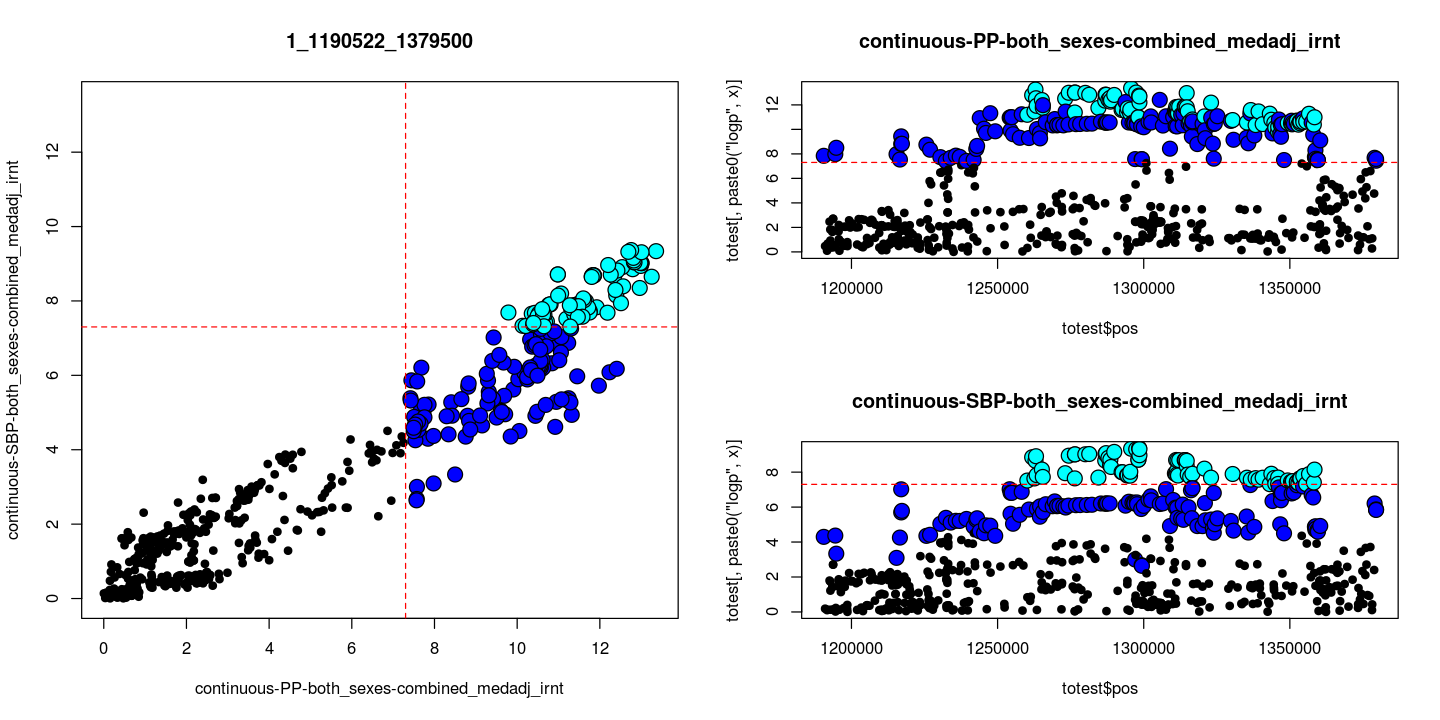

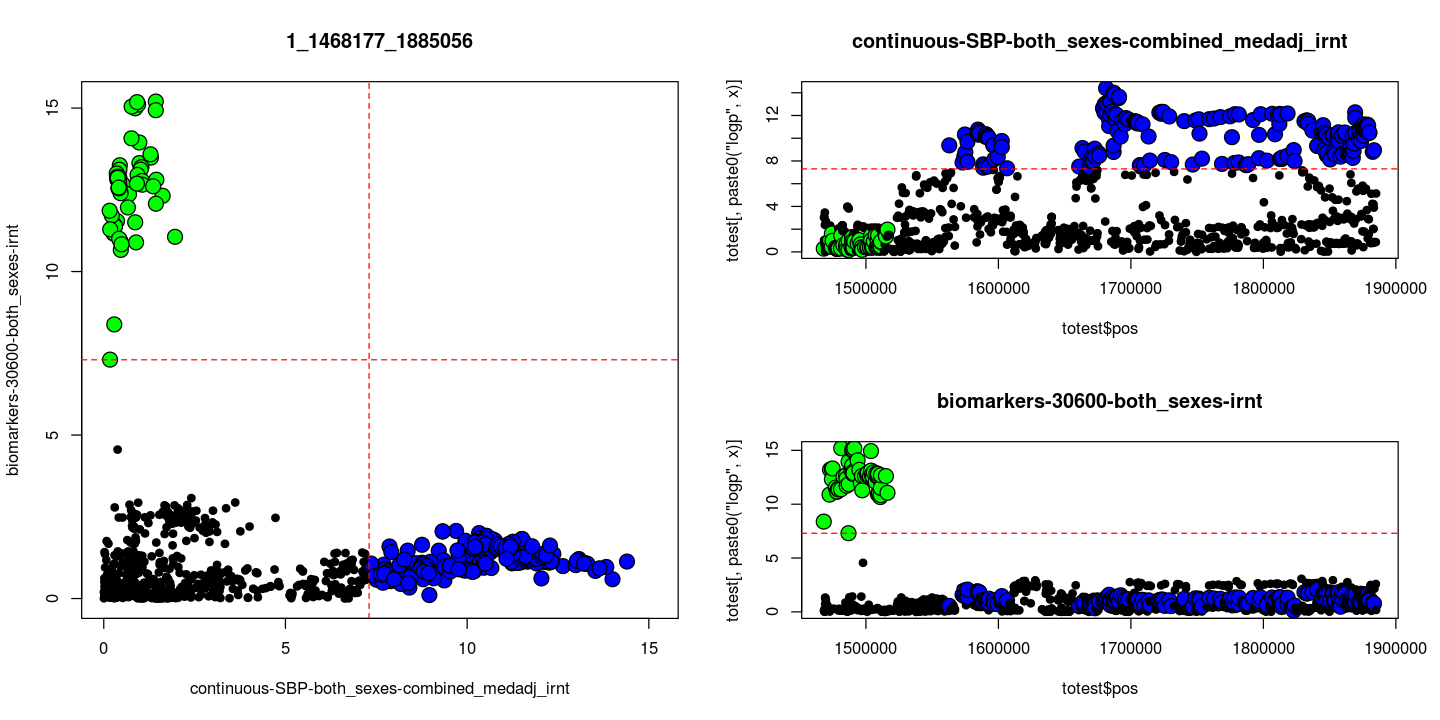

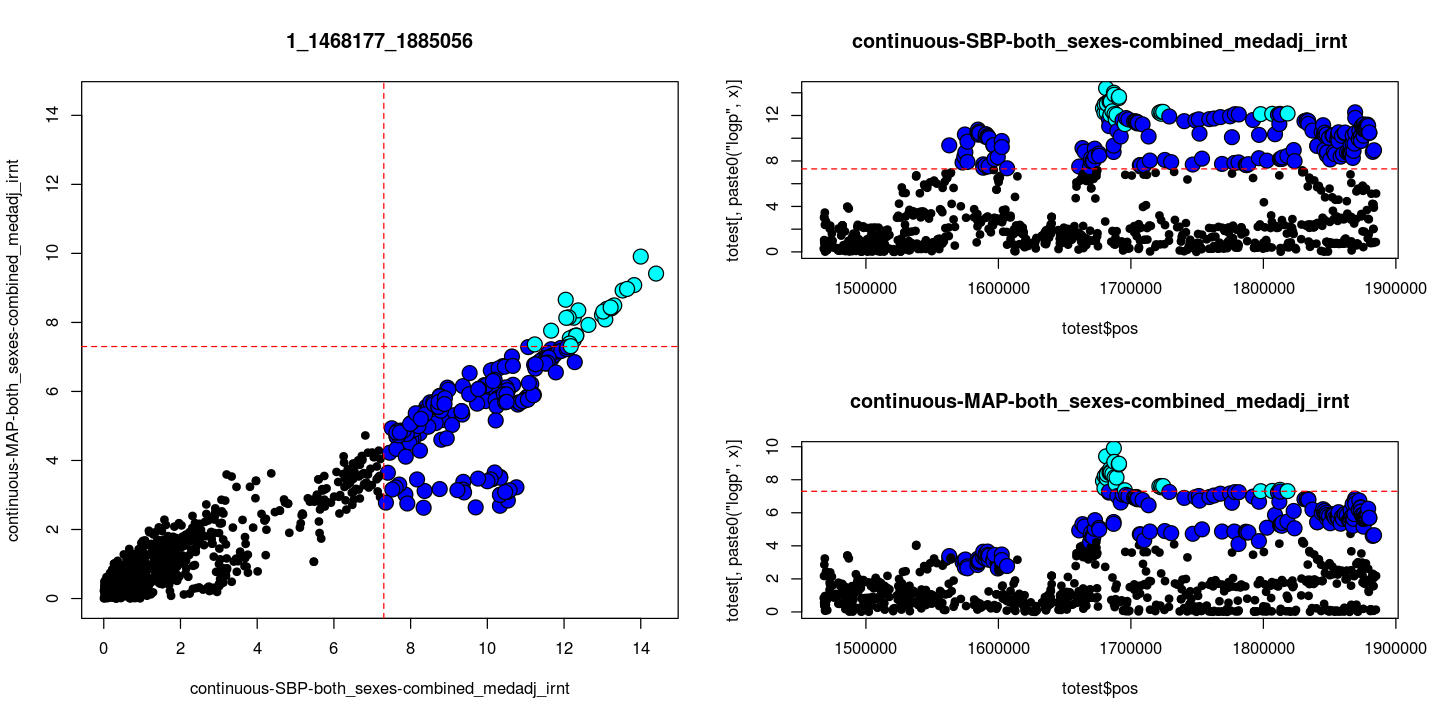

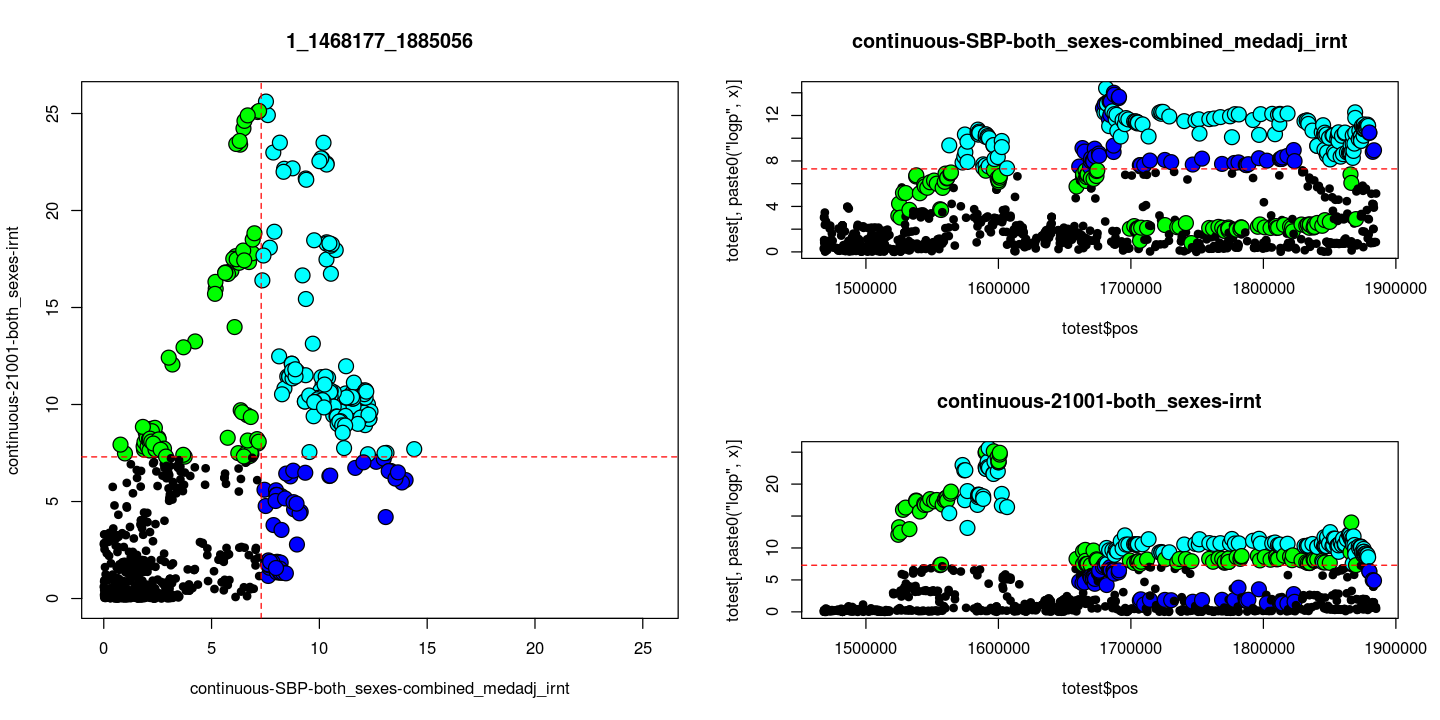

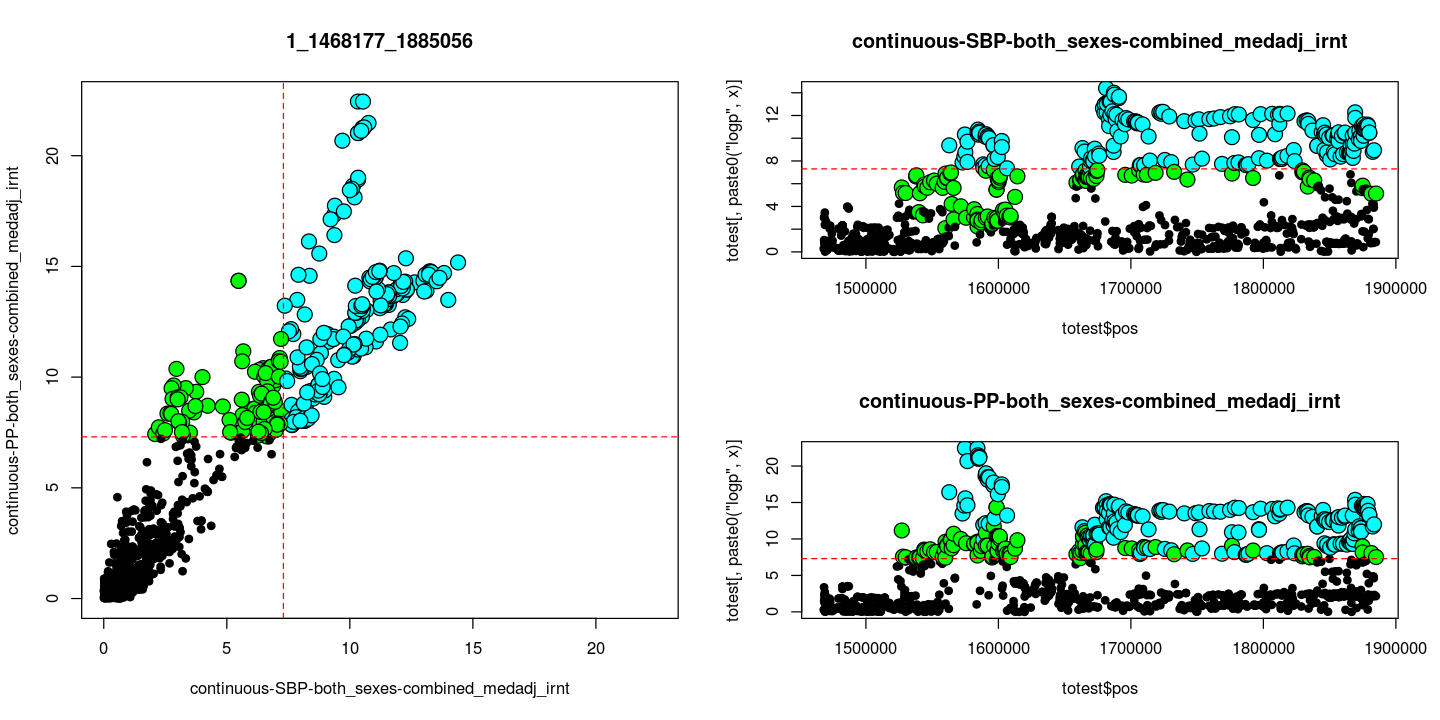

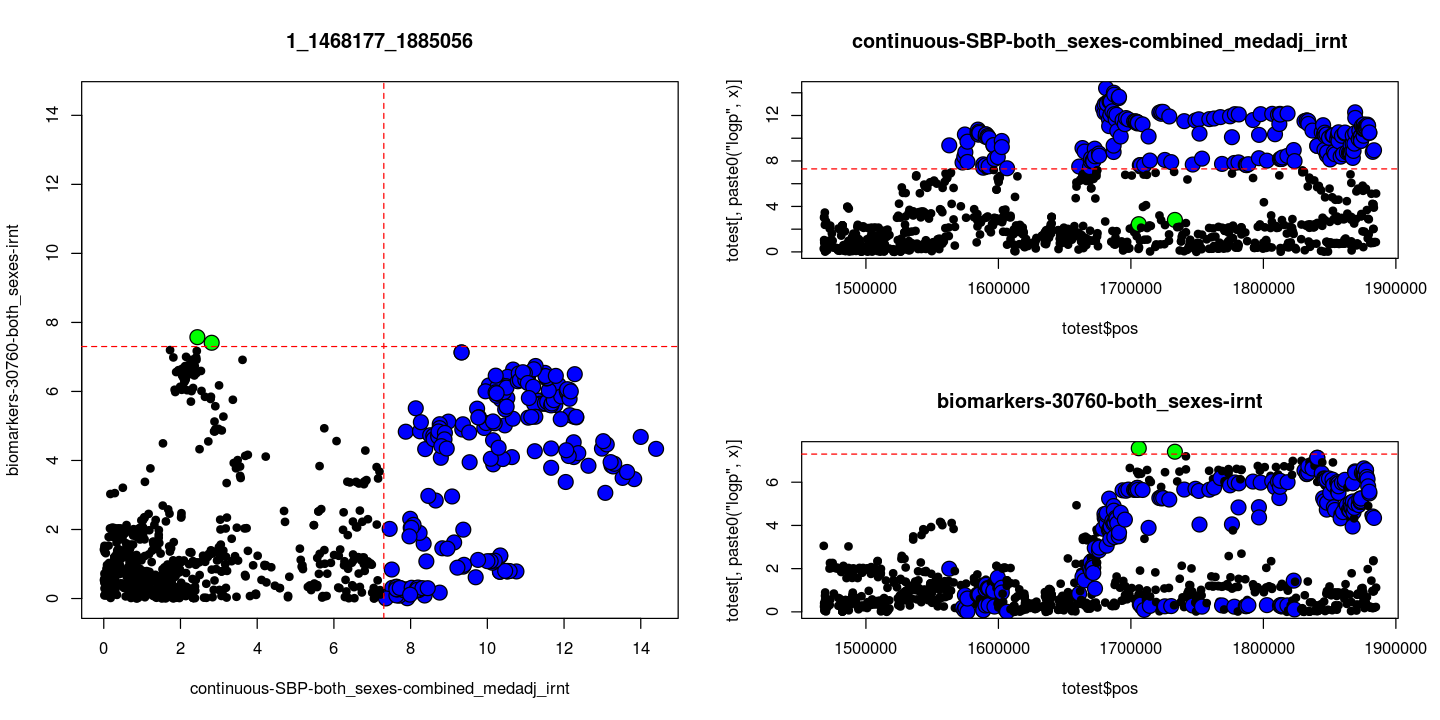

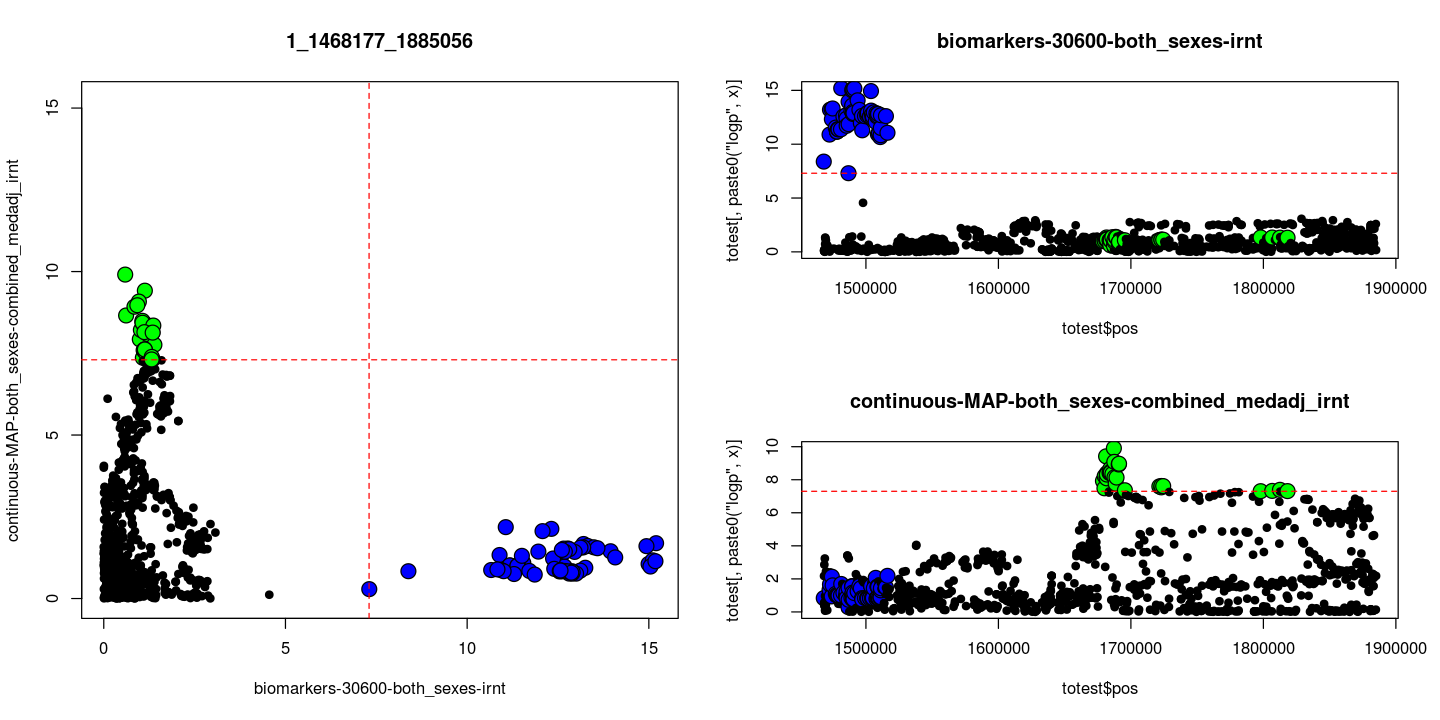

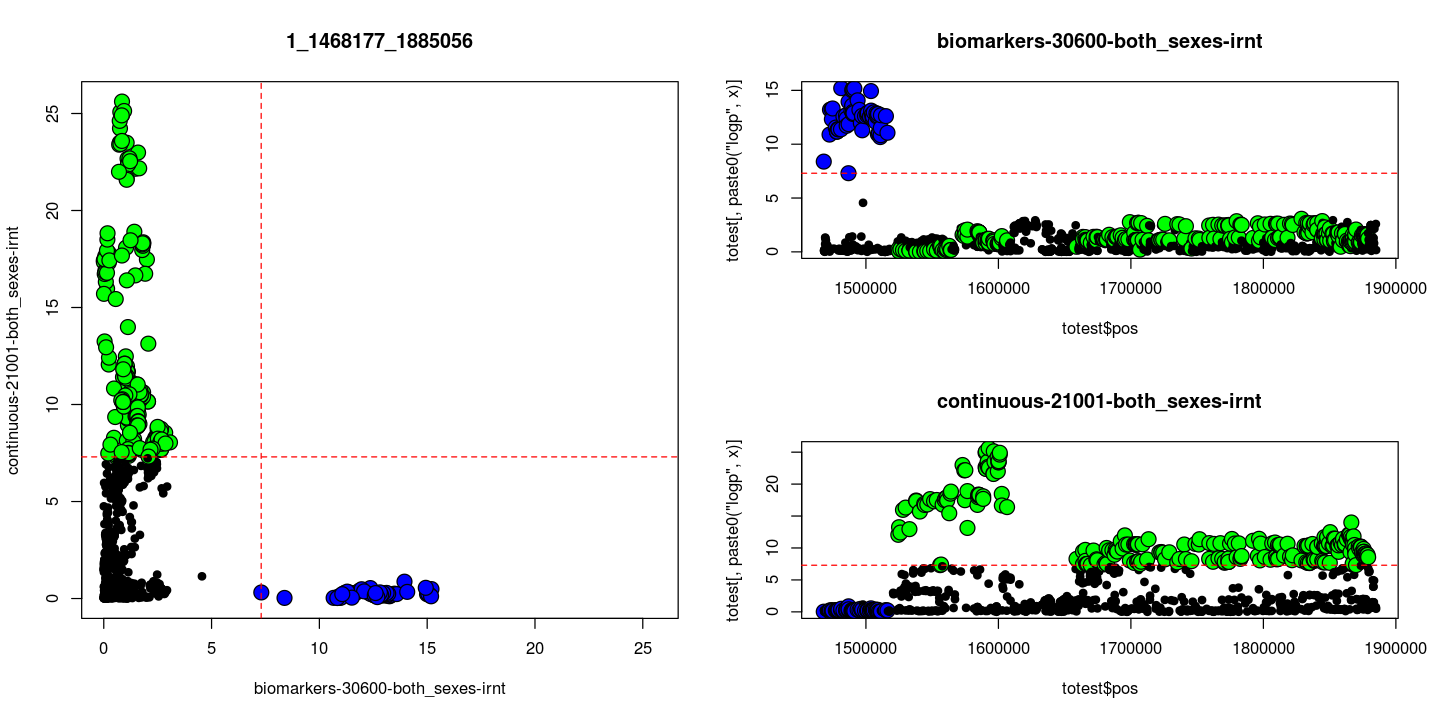

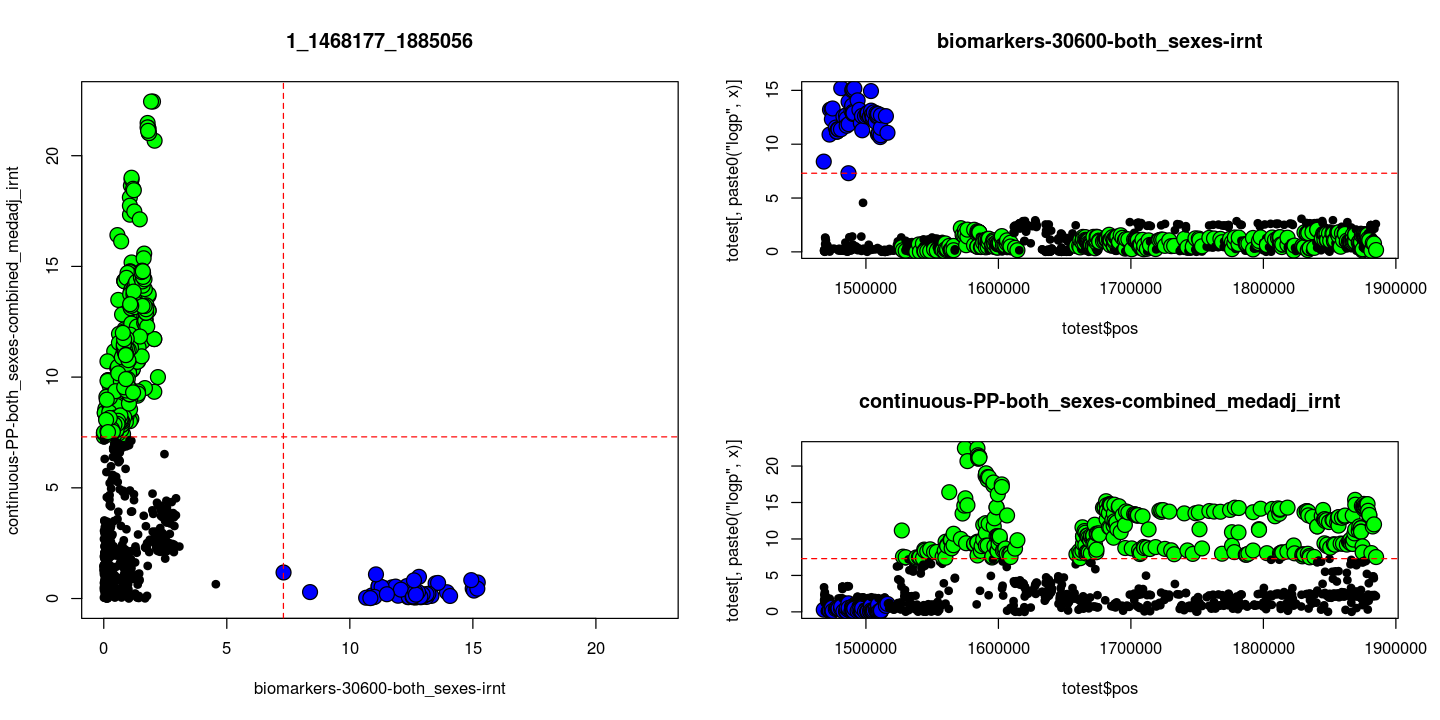

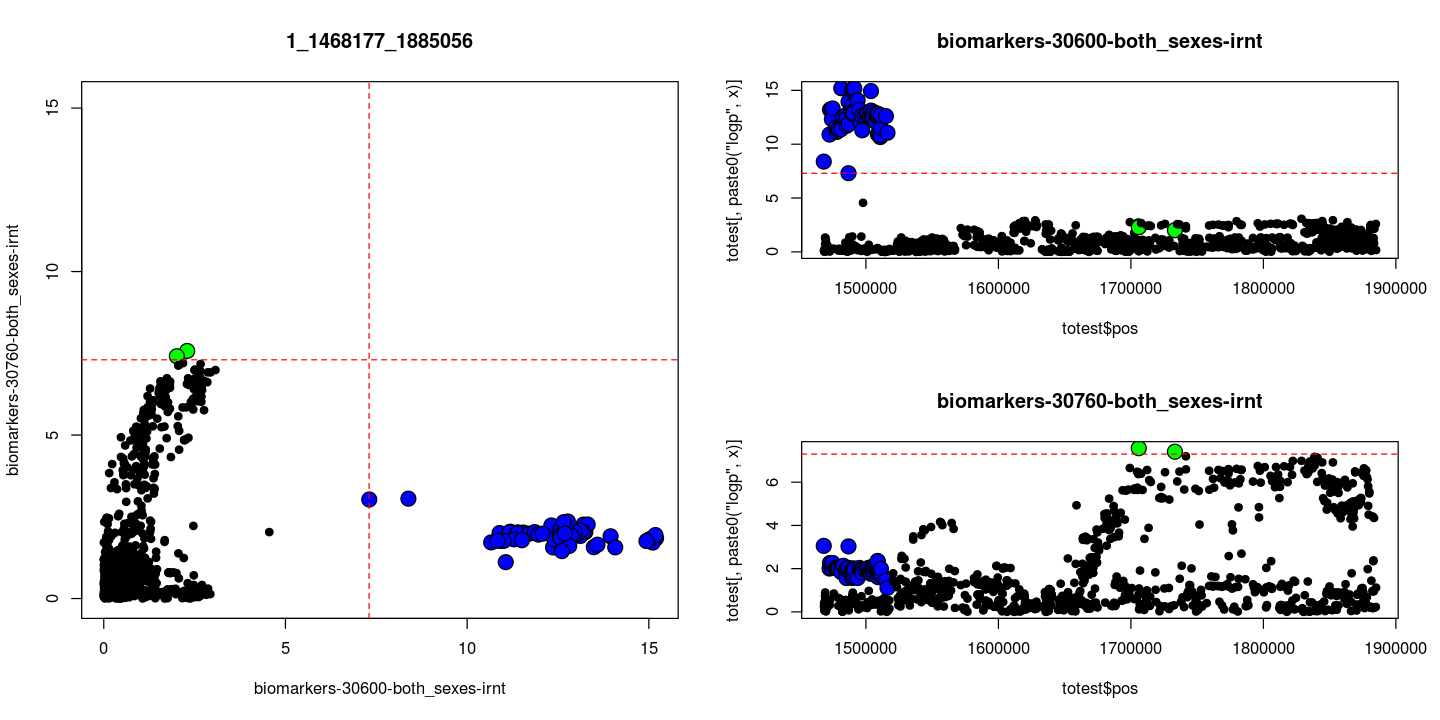

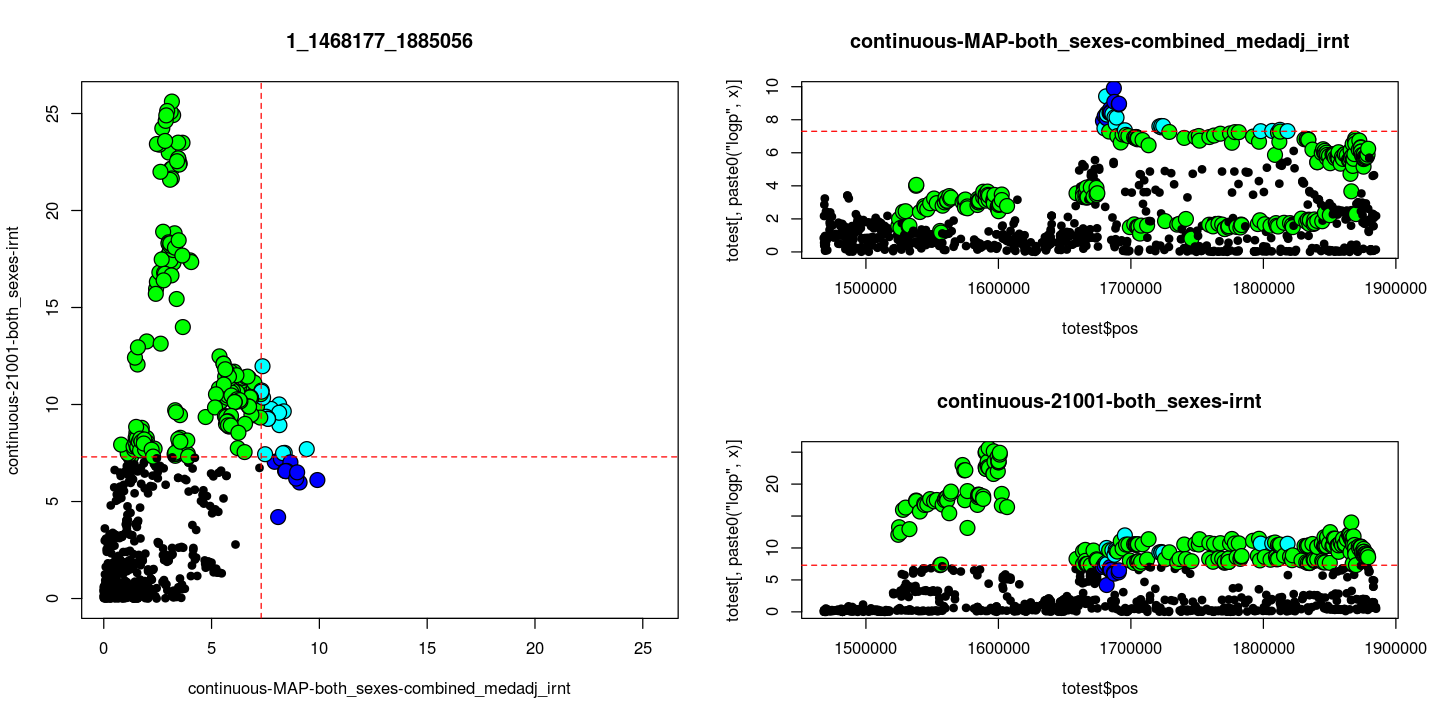

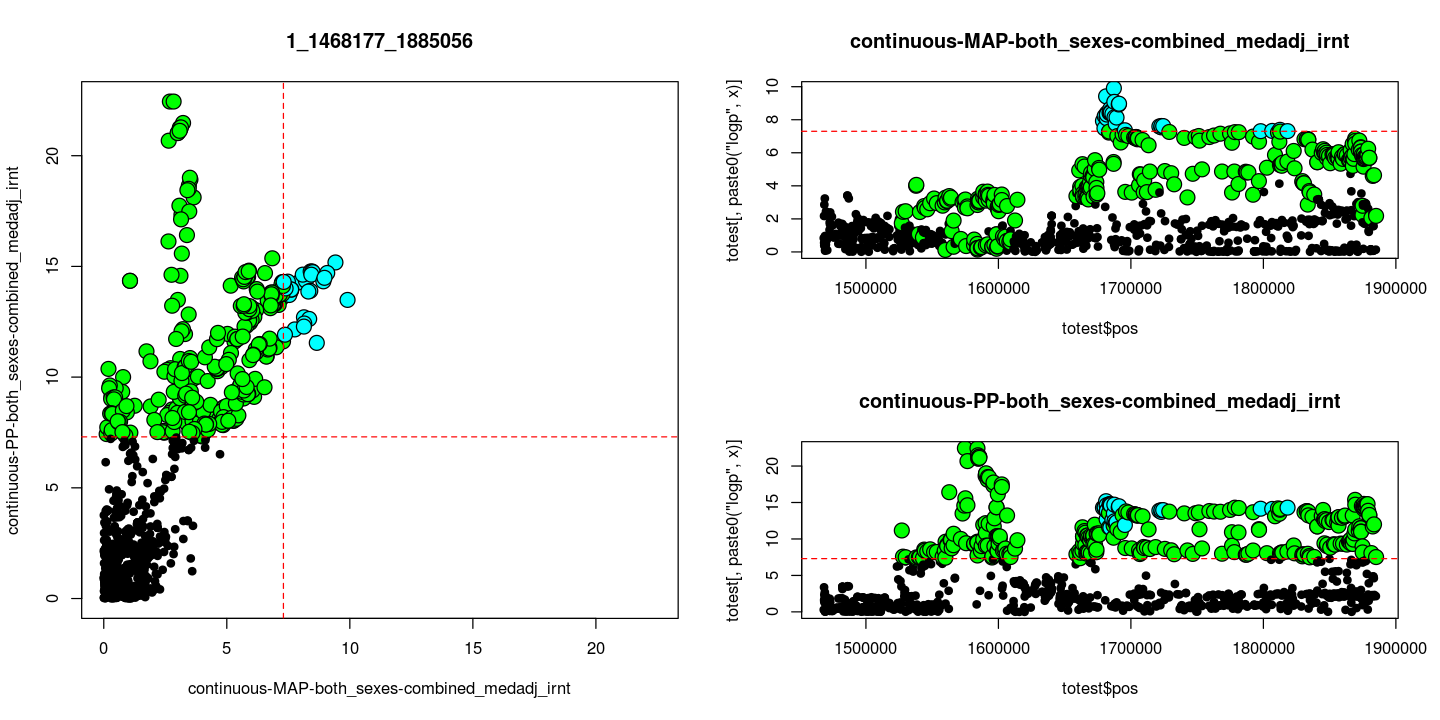

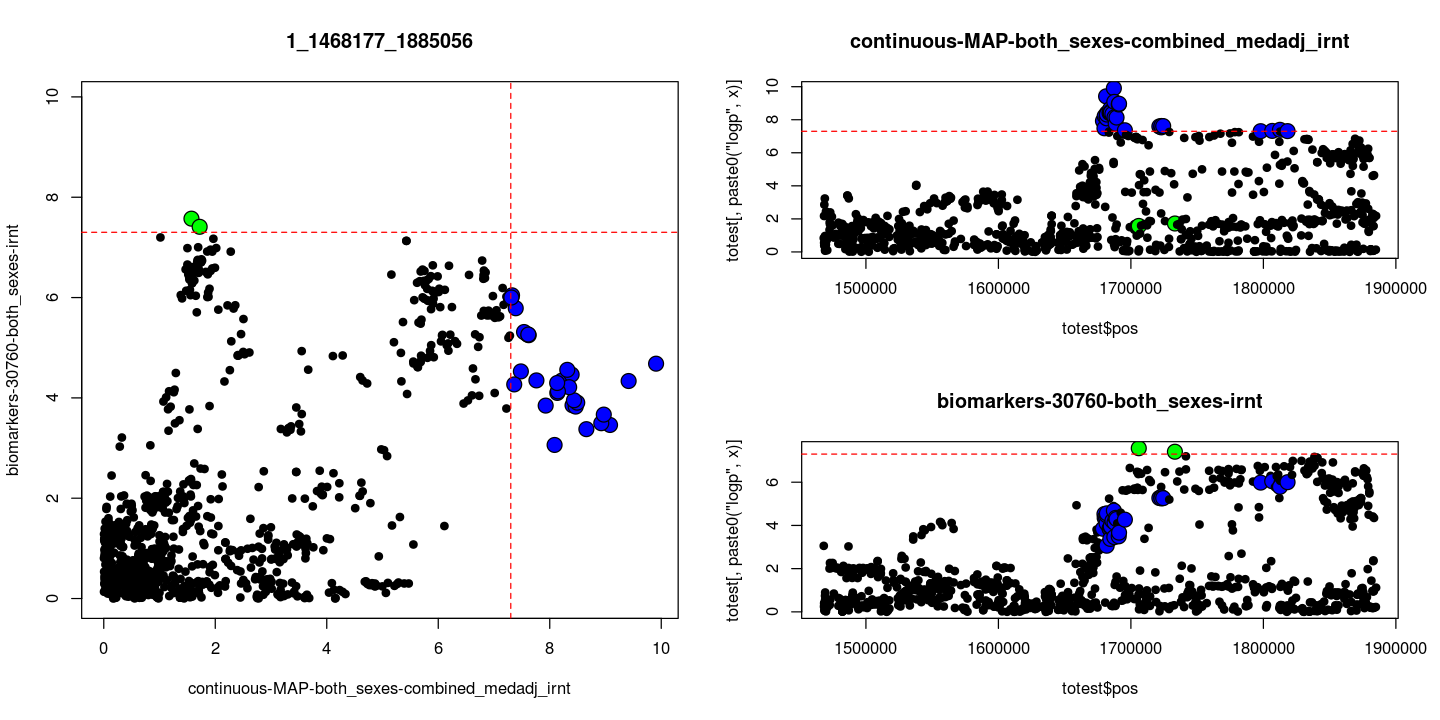

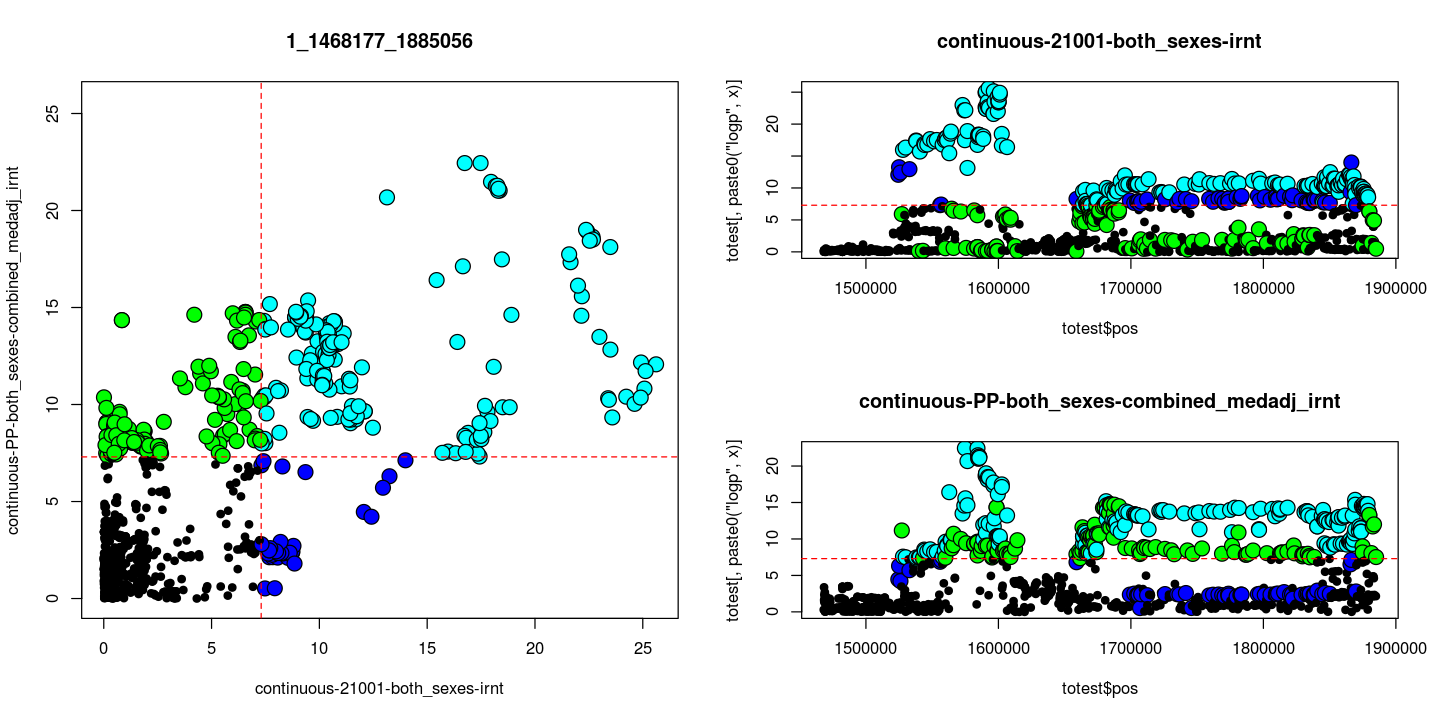

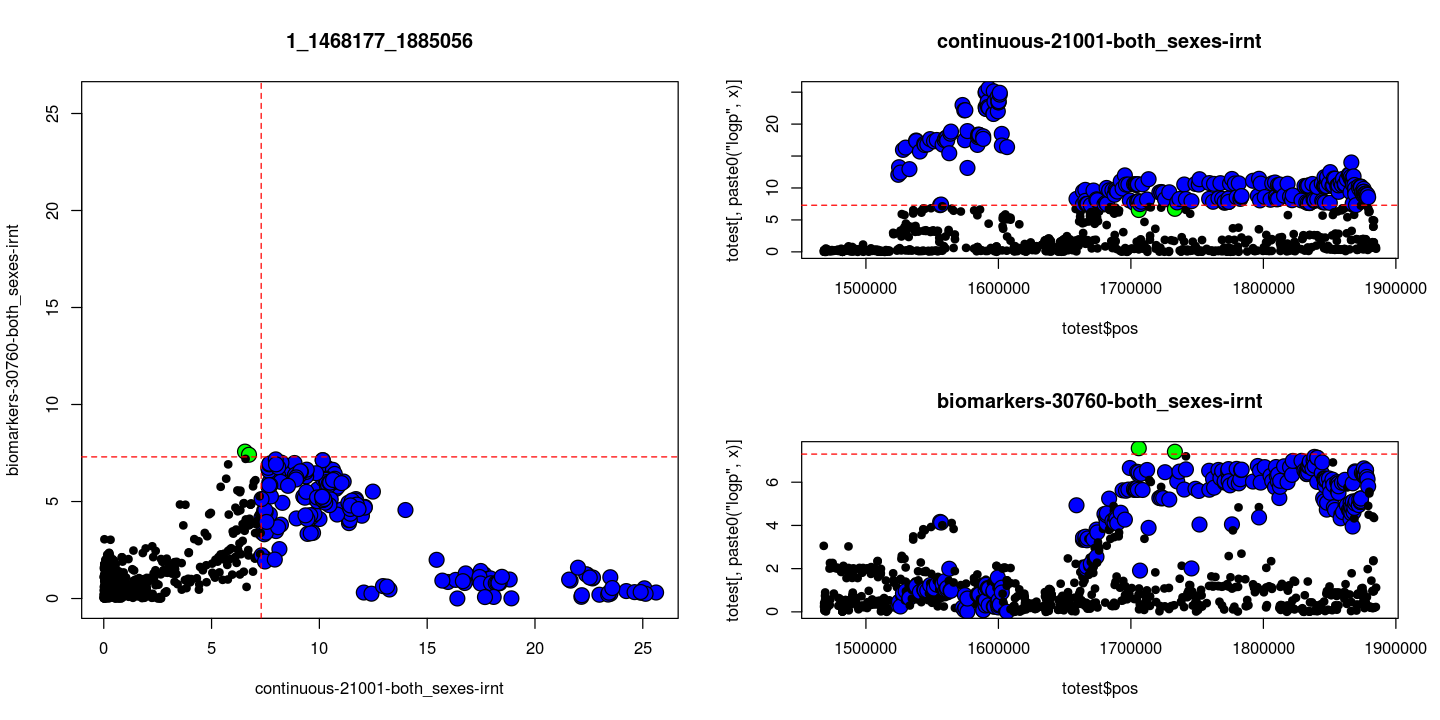

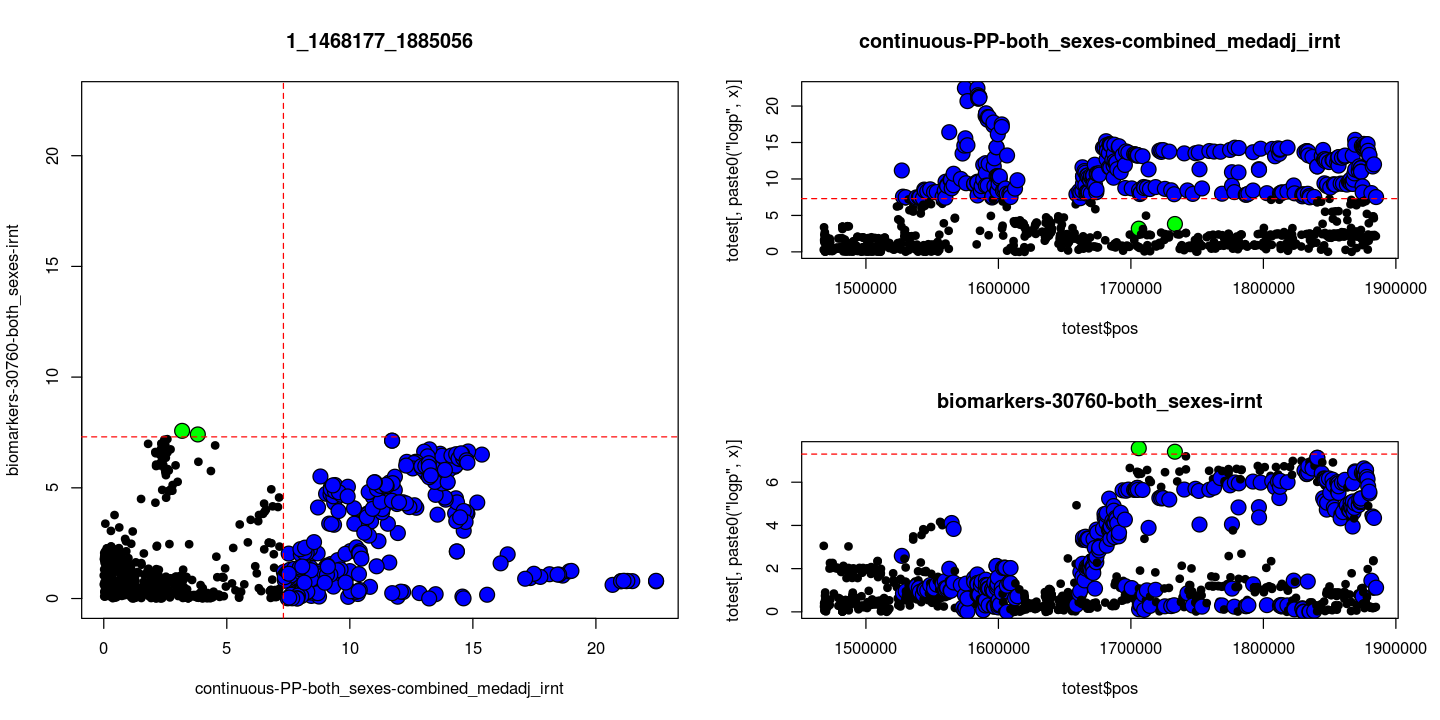

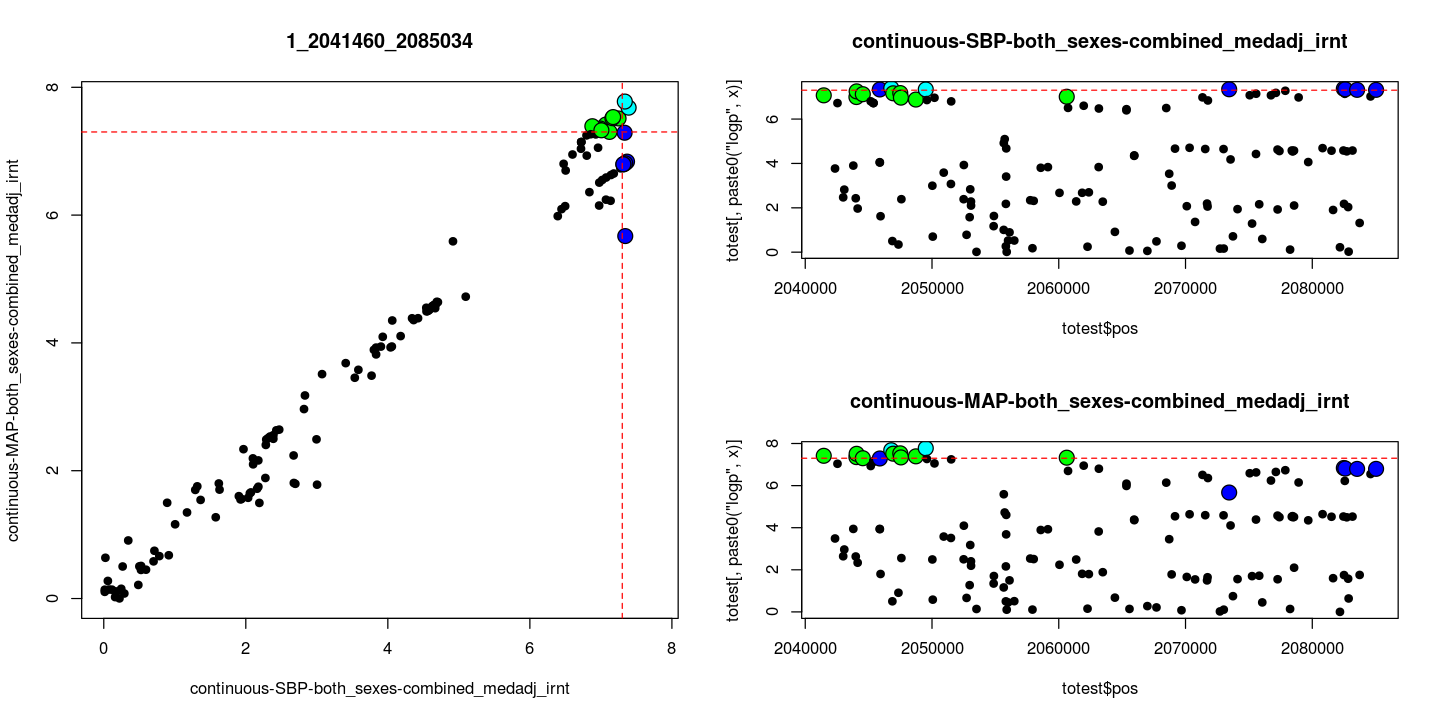

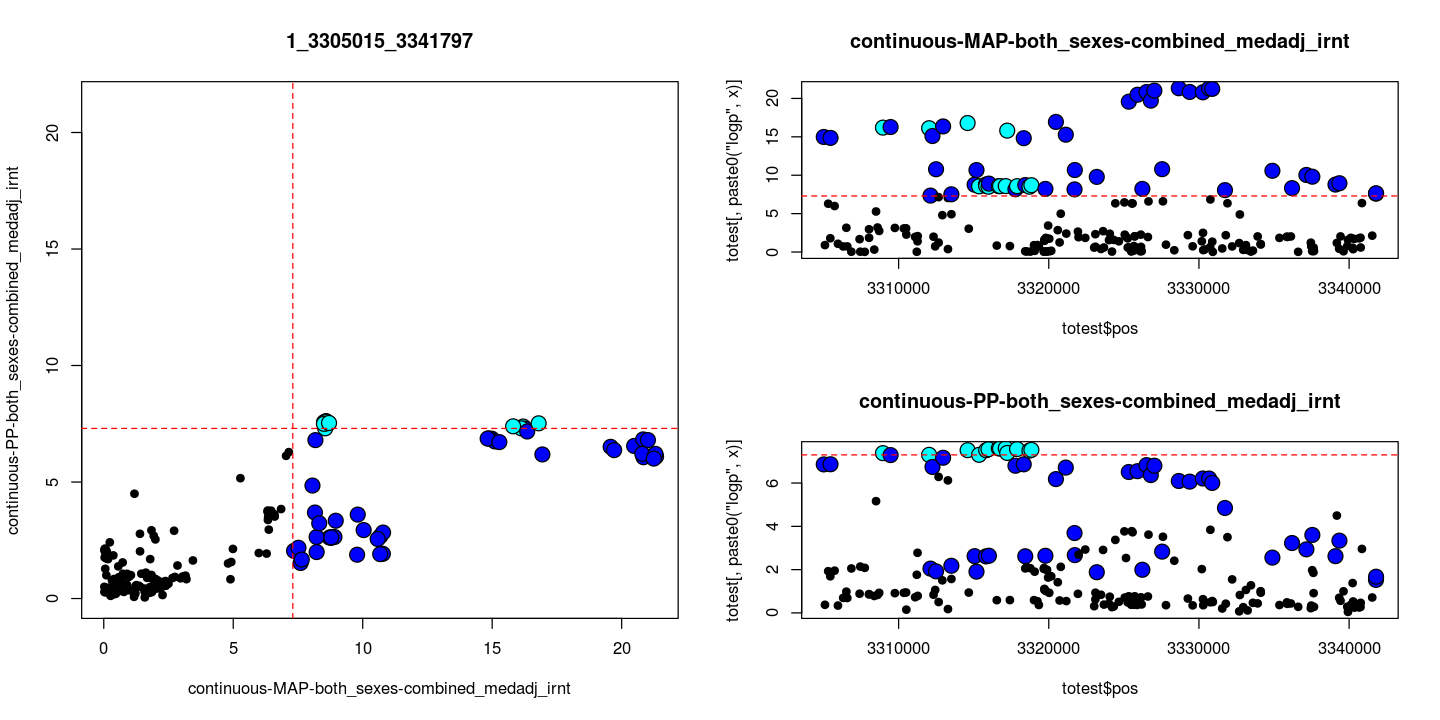

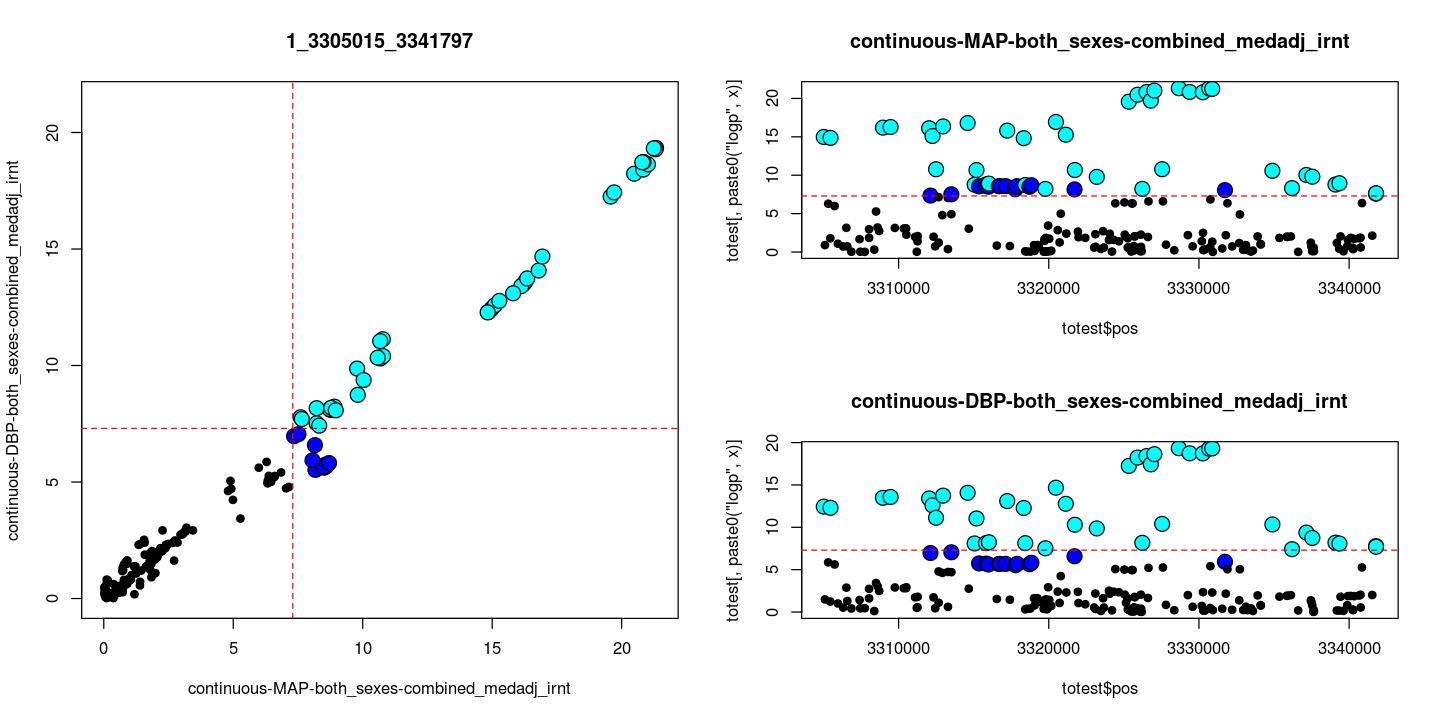

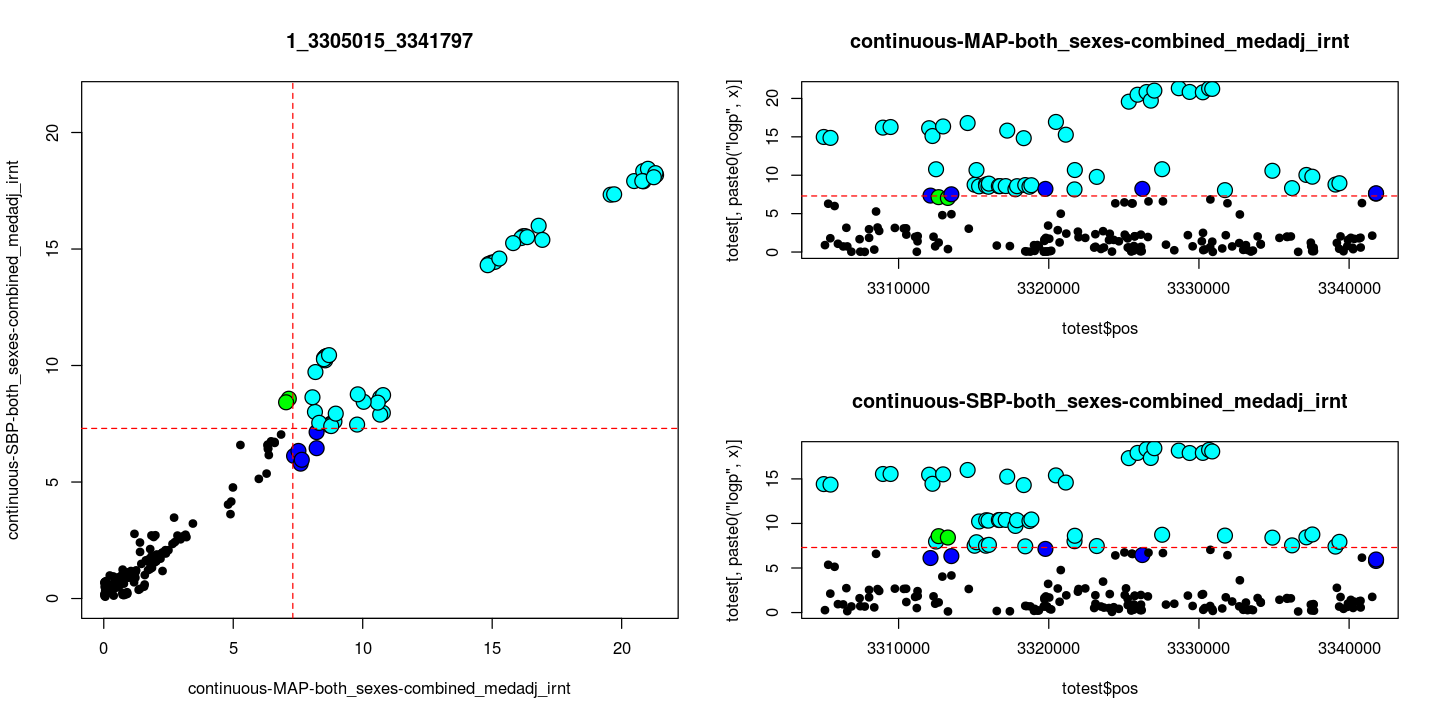

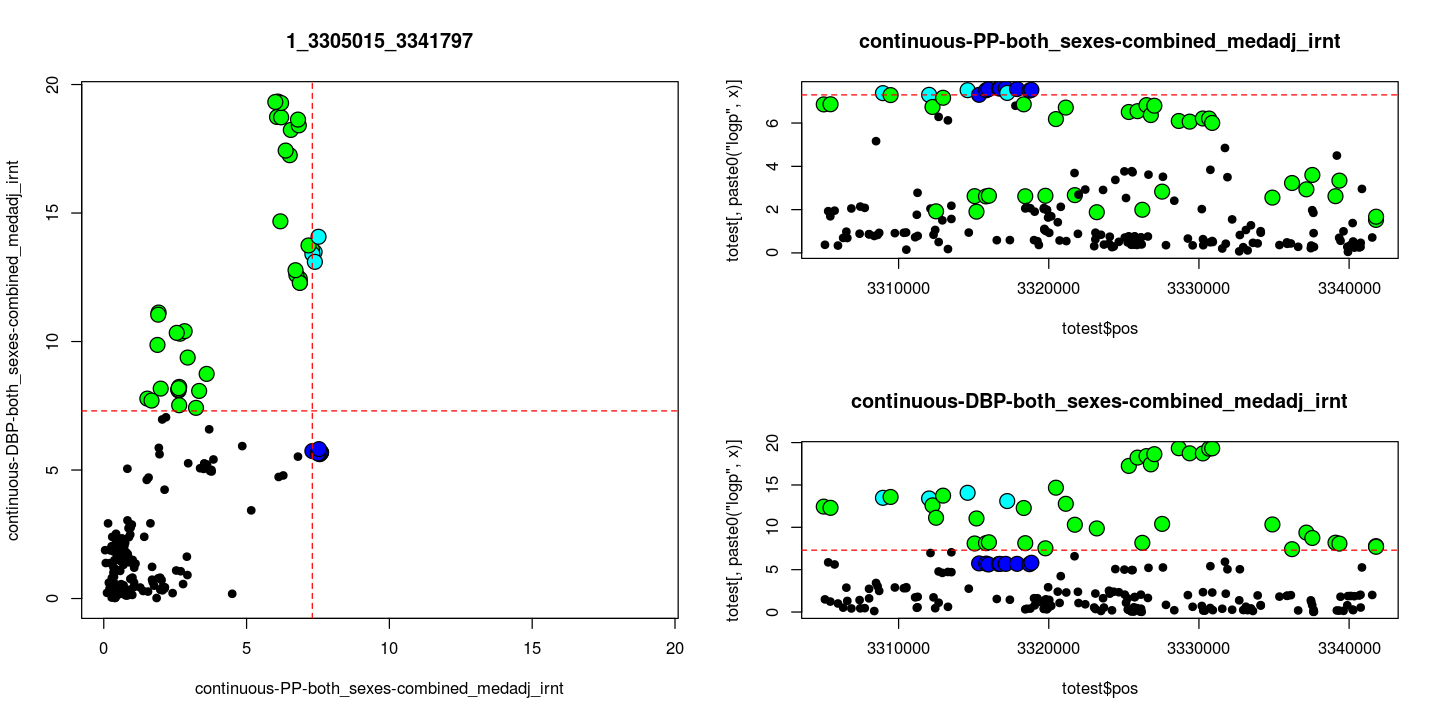

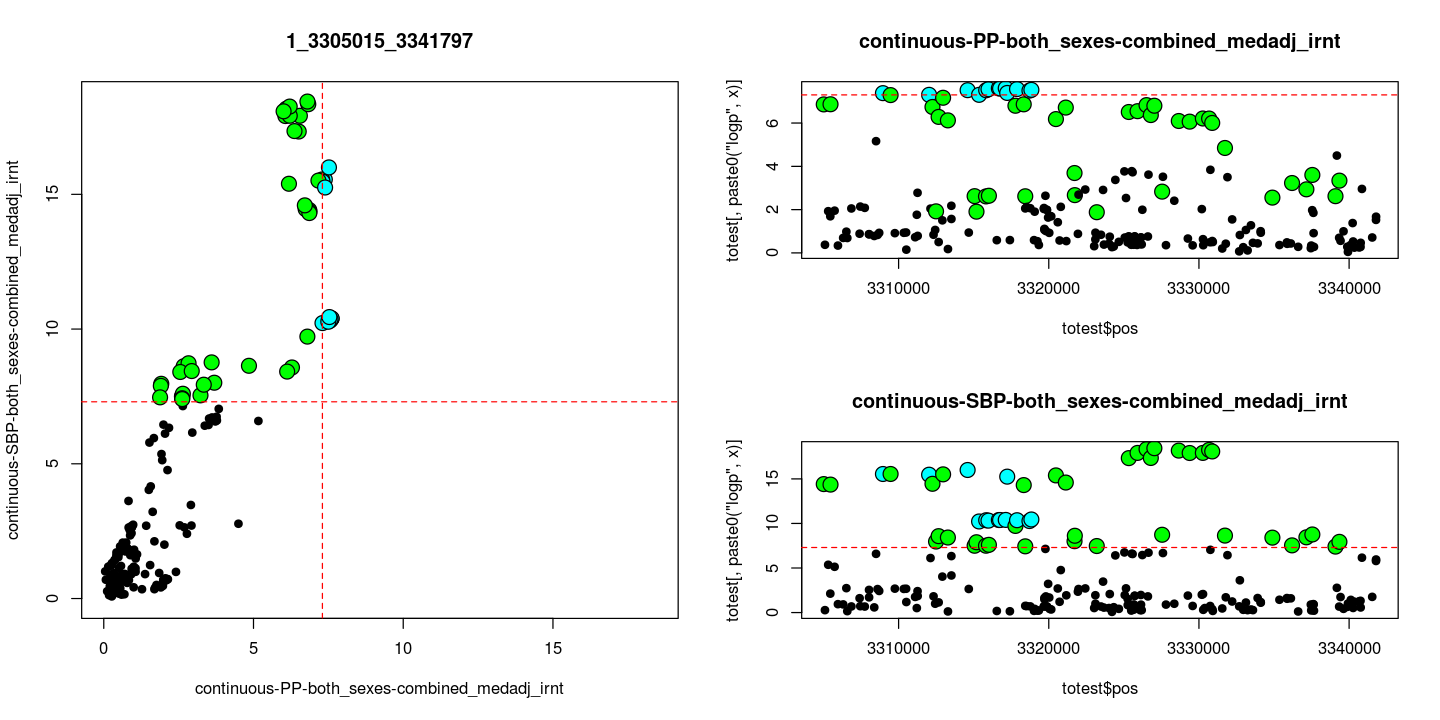

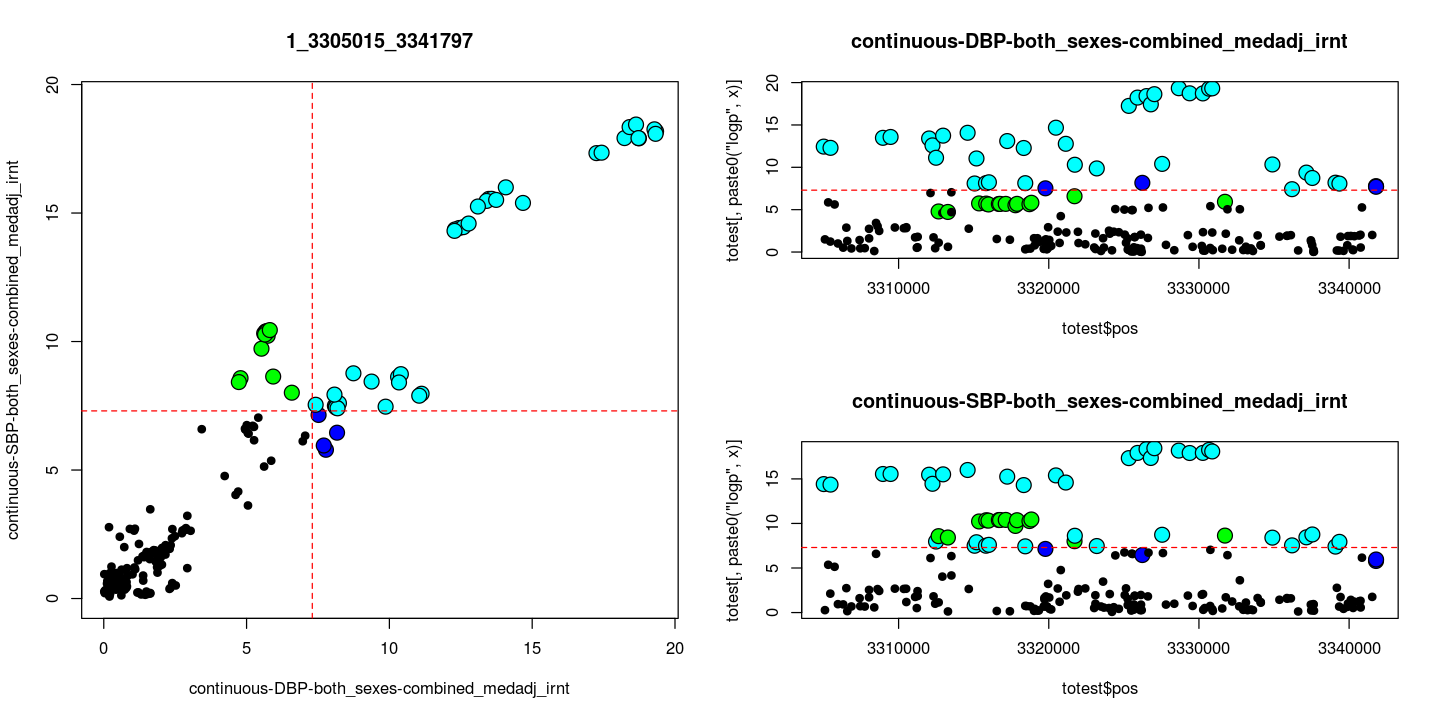

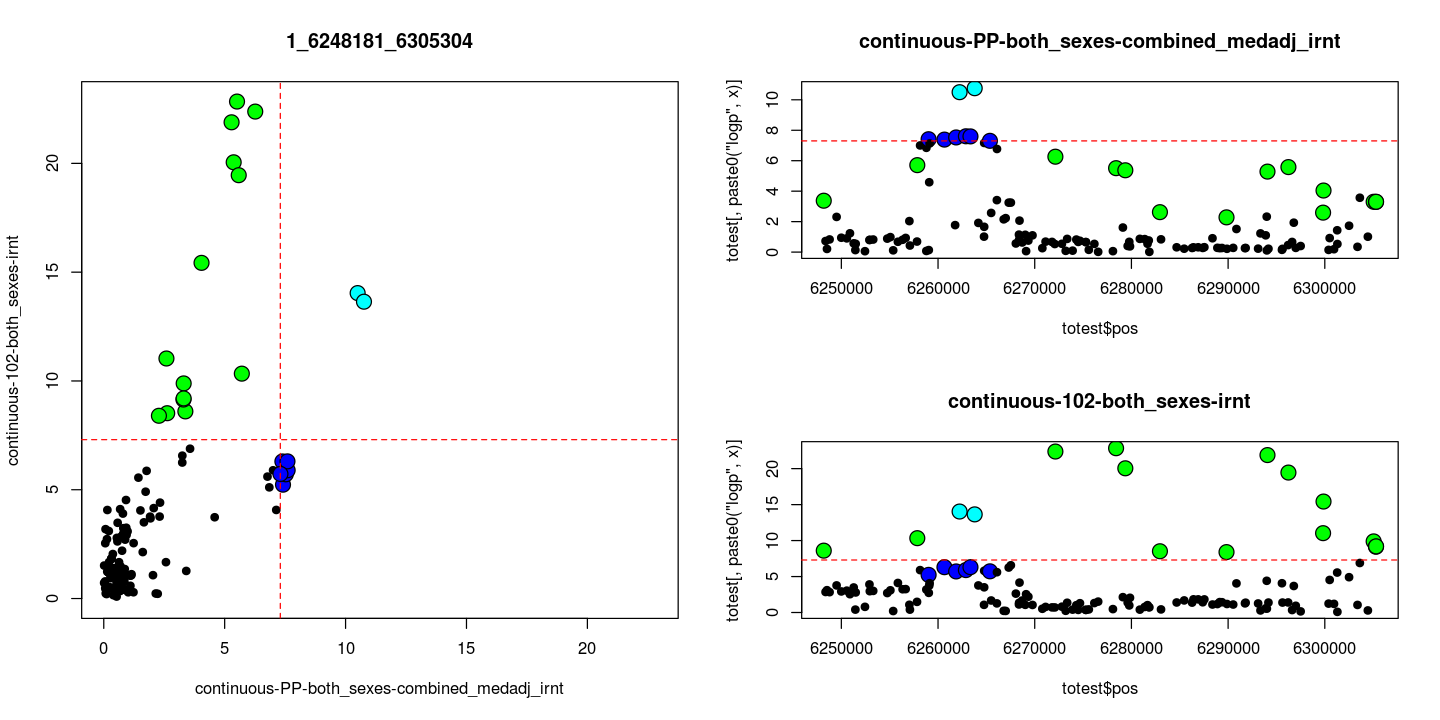

In [365]:
plot_gwas = function(trait, x, totest )
{
    plot(totest$pos, totest[, paste0("logp", x)], pch = 21, cex = totest$cex, bg = totest$color, main = trait)
    abline(h = -log10(5e-8), lty = "dashed", col = "#ff0000")
    
}


test_pairwise_fisher = function(totest)
{
    mymat = data.frame(x11 = nrow(totest[totest$pval1 <= 5e-8 & totest$pval2 <= 5e-8, ]),
                       x12 = nrow(totest[totest$pval1 <= 5e-8 & totest$pval2 >  5e-8, ]),
                       x21 = nrow(totest[totest$pval1 >  5e-8 & totest$pval2 <= 5e-8, ]),
                       x22 = nrow(totest[totest$pval1 >  5e-8 & totest$pval2 >  5e-8, ])
                      )
    
    test = fisher.test(matrix(as.numeric(mymat[1,]), nrow = 2, byrow = TRUE))
    out  = cbind(mymat, data.frame(estimate = test$estimate, 
                                   ci1      = test$conf.int[[1]], 
                                   ci2      = test$conf.int[[2]], 
                                   pval     = test$p.value))
    
    return(out)
}

test_pairwise_lm = function(totest)
{
    #totest$weight = rowMeans(totest[,c("logp1", "logp2")])
    totest$weight = unlist(apply(totest[,c("logp1", "logp2")], 1, max))
    out           = as.data.frame(coefficients(summary(lm(pval2 ~ pval1, data = totest, weights = totest$weight / max(totest$weight)))))
    out           = out["pval1", c(1,2,4)]
    colnames(out) = c("beta", "se", "pval")
    
    top1        = totest[order(totest$pval1), "pos"][1:20]
    top2        = totest[order(totest$pval2), "pos"][1:20]
    out$overlap = length(intersect(top1, top2)) / length(union(top1, top2))
    
    return(out)
}

test_pairwise = function(locus, trait1, trait2, snps_by_locus_list)
{
    x1 = snps_by_locus_list[[locus]][[trait1]]
    x2 = snps_by_locus_list[[locus]][[trait2]]
    
    totest = merge(x1[,c("pos", "variant_id", "pval", "logp")], x2[,c("pos", "variant_id", "pval", "logp")], by = c("pos", "variant_id"), suffixes = 1:2)
    totest$cat = "NS"
    
    totest[totest$pval1 <= 5e-8 & totest$pval2 <= 5e-8, "cat"] = "both"
    totest[totest$pval1 <= 5e-8 & totest$pval2 >  5e-8, "cat"] = "only1"
    totest[totest$pval1 >  5e-8 & totest$pval2 <= 5e-8, "cat"] = "only2"
    
    totest$color = mapvalues(x =totest$cat, from = c("NS", "both", "only1", "only2"), to = c("#000000", "#00ffff", "#0000ff", "#00ff00"), warn_missing = FALSE)
    
    totest$cex = 2
    
    totest[totest$cat == "NS", "cex"] = 1
    
    options(repr.plot.width = 12, repr.plot.height = 6)
    layout(cbind(rep(1,2), 2:3))
    
    mylim = max(c(totest$logp1, totest$logp2))
    plot(totest$logp1, totest$logp2, pch = 21, cex = totest$cex, bg = totest$color, xlim = c(0, mylim), ylim = c(0, mylim), xlab = trait1, ylab = trait2, main = locus)
    
    abline(h = -log10(5e-8), lty = "dashed", col = "#ff0000")
    abline(v = -log10(5e-8), lty = "dashed", col = "#ff0000")
    
    plot_gwas(trait1, 1, totest )
    plot_gwas(trait2, 2, totest )
    
    out                   = data.frame(locus = locus, trait1 = trait1, trait2 = trait2)
    test_lm               = test_pairwise_lm    (totest)
    #test_fisher           = test_pairwise_fisher(totest)
    #colnames(test_fisher) = paste("fisher", colnames(test_fisher), sep = ".")
    #colnames(test_lm    ) = paste("lm"    , colnames(test_lm    ), sep = ".")
    
    return(cbind(out, test_lm))
}

test_pairwise_fisher_by_locus = function(locus, trait2locus_trait, snps_by_locus_list)
{
    traits                  = trait2locus_trait[ trait2locus_trait$locus == locus, "trait"]
    if(length(traits) > 1)
    {
        pairs_to_test           = as.data.frame(t(combn(traits, 2)))
        colnames(pairs_to_test) = c("trait1", "trait2")
        tests                   = as.data.frame(rbindlist(lapply(1:nrow(pairs_to_test), function(ii)
        {
            test_pairwise(locus, pairs_to_test[ii, "trait1"], pairs_to_test[ii, "trait2"], snps_by_locus_list)
        })), stringsAsFactors = FALSE)
    }else
    {
        tests = data.frame(locus = locus, trait1 = traits[[1]], trait2 = "", beta = 0, se = 1, pval = 1, overlap = 0)
    }
    
    return(tests)
}

tests_pairwise_overlap = as.data.frame(rbindlist(lapply(totest_loci, function(locus){test_pairwise_fisher_by_locus(locus, trait2locus_trait, snps_by_locus_list)})), stringsAsFactors = FALSE)

fwrite(tests_pairwise_overlap, "pipeline/eqtl.2.1.genomewide_significant_loci/tests_pairwise_overlap.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [364]:
tests_pairwise_overlap

locus             trait1                                        
1  1_1065799_1103151 biomarkers-30680-both_sexes-irnt              
2  1_1190522_1379500 continuous-PP-both_sexes-combined_medadj_irnt 
3  1_1468177_1885056 continuous-SBP-both_sexes-combined_medadj_irnt
4  1_1468177_1885056 continuous-SBP-both_sexes-combined_medadj_irnt
5  1_1468177_1885056 continuous-SBP-both_sexes-combined_medadj_irnt
6  1_1468177_1885056 continuous-SBP-both_sexes-combined_medadj_irnt
7  1_1468177_1885056 continuous-SBP-both_sexes-combined_medadj_irnt
8  1_1468177_1885056 biomarkers-30600-both_sexes-irnt              
9  1_1468177_1885056 biomarkers-30600-both_sexes-irnt              
10 1_1468177_1885056 biomarkers-30600-both_sexes-irnt              
11 1_1468177_1885056 biomarkers-30600-both_sexes-irnt              
12 1_1468177_1885056 continuous-MAP-both_sexes-combined_medadj_irnt
13 1_1468177_1885056 continuous-MAP-both_sexes-combined_medadj_irnt
14 1_1468177_1885056 continuous-MAP-both_sexes-combined_medadj_irnt
15 1_1468177_1885056 continuous-21001-both_sexes-irnt              
16 1_1468177_1885056 continuous-21001-both_sexes-irnt              
17 1_1468177_1885056 continuous-PP-both_sexes-combined_medadj_irnt 
18 1_2041460_2085034 continuous-SBP-both_sexes-combined_medadj_irnt
19 1_2278256_2278256 continuous-21001-both_sexes-irnt              
20 1_2427711_2444415 continuous-21001-both_sexes-irnt              
21 1_2692476_2753373 continuous-21001-both_sexes-irnt              
22 1_2984087_2984087 phecode-411.2-both_sexes                      
23 1_3305015_3341797 continuous-MAP-both_sexes-combined_medadj_irnt
24 1_3305015_3341797 continuous-MAP-both_sexes-combined_medadj_irnt
25 1_3305015_3341797 continuous-MAP-both_sexes-combined_medadj_irnt
26 1_3305015_3341797 continuous-PP-both_sexes-combined_medadj_irnt 
27 1_3305015_3341797 continuous-PP-both_sexes-combined_medadj_irnt 
28 1_3305015_3341797 continuous-DBP-both_sexes-combined_medadj_irnt
29 1_6248181_6305304 continuous-PP-both_sexes-combined_medadj_irnt 
   trait2                                         beta        se        
1                                                  0.00000000 1.00000000
2  continuous-SBP-both_sexes-combined_medadj_irnt  1.11932516 0.07494590
3  biomarkers-30600-both_sexes-irnt               -0.31163158 0.05309880
4  continuous-MAP-both_sexes-combined_medadj_irnt  0.95194319 0.04755640
5  continuous-21001-both_sexes-irnt                0.34282107 0.06023008
6  continuous-PP-both_sexes-combined_medadj_irnt   0.48621713 0.02498770
7  biomarkers-30760-both_sexes-irnt               -0.01500745 0.06961255
8  continuous-MAP-both_sexes-combined_medadj_irnt -0.03608869 0.02229263
9  continuous-21001-both_sexes-irnt               -0.21594310 0.02854740
10 continuous-PP-both_sexes-combined_medadj_irnt  -0.20733843 0.02790405
11 biomarkers-30760-both_sexes-irnt                0.14911714 0.02725232
12 continuous-21001-both_sexes-irnt                0.33124144 0.04323257
13 continuous-PP-both_sexes-combined_medadj_irnt   0.05369145 0.01526683
14 biomarkers-30760-both_sexes-irnt                0.05289346 0.04190392
15 continuous-PP-both_sexes-combined_medadj_irnt   0.03539635 0.01591608
16 biomarkers-30760-both_sexes-irnt                0.05299880 0.04151771
17 biomarkers-30760-both_sexes-irnt               -0.11860505 0.06435238
18 continuous-MAP-both_sexes-combined_medadj_irnt  0.76748812 0.04142851
19                                                 0.00000000 1.00000000
20                                                 0.00000000 1.00000000
21                                                 0.00000000 1.00000000
22                                                 0.00000000 1.00000000
23 continuous-PP-both_sexes-combined_medadj_irnt   0.08618003 0.04826790
24 continuous-DBP-both_sexes-combined_medadj_irnt  0.65279598 0.04061421
25 continuous-SBP-both_sexes-combined_medadj_irnt  0.46285941 0.04055916
26 continuous-DBP-both_sexes-combined_medadj_irnt  0.17376730 0.0

In [297]:
str(loci_merged)

List of 2
 $ loci       :'data.frame':	3651 obs. of  9 variables:
  ..$ chrom   : int [1:3651] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ from    : int [1:3651] 1065799 1190522 1468177 2041460 2278256 2427711 2692476 2984087 3305015 6248181 ...
  ..$ to      : int [1:3651] 1103151 1379500 1885056 2085034 2278256 2444415 2753373 2984087 3341797 6305304 ...
  ..$ loci_n  : int [1:3651] 1 2 9 2 1 1 1 1 4 2 ...
  ..$ traits_n: int [1:3651] 1 2 6 2 1 1 1 1 4 2 ...
  ..$ traits  : chr [1:3651] "biomarkers-30680-both_sexes-irnt" "continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt" "biomarkers-30600-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-M"| __truncated__ "continuous-MAP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt" ...
  ..$ distance: num [1:3651] -1 87371 88677 156404 193222 ...
  ..$ locus   : chr [1:3651] "1_1065799_1103151" "1_1190522_1379500" "1_1468177_1885056" "1_2041460

In [210]:
trait2locus = unique(loci_merged[[2]])

str(trait2locus)

'data.frame':	10990 obs. of  3 variables:
 $ locus_trait: chr  "1_1468177_1516271" "1_9434968_9454254" "1_11070918_11326923" "1_16388473_16731511" ...
 $ locus      : chr  "1_1468177_1885056" "1_9434583_9456514" "1_11070918_11360958" "1_16388473_16731511" ...
 $ trait      : chr  "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" ...


# OLD

# Overlap loci/trait

In [54]:
suppressPackageStartupMessages(library(reshape2))

In [46]:
dir.create("pipeline/eqtl.5.overlap_traits"      , showWarnings = FALSE)


In [3]:
exp_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")
qtl_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )


# At each locus that is genome wide-significant, find all SNPs that are genome-wide significant

In [126]:
get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))
    colnames(gwas_data)  = my_head
    gwas_data$variant_id = paste(gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$variant_id
    gwas_data$pval       = unlist(apply(gwas_data[, grepl("pval", colnames(gwas_data)) == TRUE & !colnames(gwas_data) %in% c("pval_heterogeneity")], 1, function(x){min(x, na.rm = TRUE)}))
    gwas_data$beta       = gwas_data$beta_meta
    
    return(gwas_data[ gwas_data$pval <= 5e-8,c("pos", "ref", "alt", "variant_id", "beta", "pval")])
}

pairwise_overlap = function(trait1, trait2, gwas)
{
    my_union        = length(unique(c (gwas[[trait1]][,"variant_id"], gwas[[trait2]][,"variant_id"])))
    my_intersection = length(intersect(gwas[[trait1]][,"variant_id"], gwas[[trait2]][,"variant_id"] ))
    
    return(data.frame(union = my_union, intersection = my_intersection))
}
    
find_significant_snps_trait_locus = function(locus, loci, manifest)
{
    coord       = sub("_", "-", sub("_", ":", locus))
    traits      = unlist(strsplit(loci[ locus, "ids"], ","))
    gwas        = lapply(traits, function(trait){get_gwas_data(coord, manifest[trait, "sumstat_file"])})
    names(gwas) = traits
    
    message(paste(locus, length(traits)), appendLF = FALSE)
    
    out = data.frame(trait = traits, 
                     locus = locus, 
                     n_significant = unlist(lapply(gwas, function(x){nrow(x)})))
    
    if(length(traits) > 1)
    {
        totest           = as.data.frame(t(as.matrix(combn(traits, 2, simplify = TRUE))))
        colnames(totest) = c("trait1", "trait2")
        pairwise         = cbind(totest, as.data.frame(rbindlist(lapply(1:nrow(totest), function(ii){pairwise_overlap(totest[ii, "trait1"], totest[ii, "trait2"], gwas)})), stringsAsFactors = FALSE))
    }else
    {
        pairwise = data.frame(trait1 = traits[[1]], trait2 = "", union = 0, intersection = 0)
    }
    
    return(list(traits = out, intersect_by_snp = pairwise, gwas = gwas))
}

loci2test            = loci$locus
locus2overlap        = lapply(loci2test, function(locus){find_significant_snps_trait_locus(locus, loci, manifest)})
names(locus2overlap) = loci2test
trait2locus          = as.data.frame(rbindlist(lapply(locus2overlap, function(x){x$traits          })), stringsAsFactors = FALSE)
fwrite(trait2locus, "pipeline/eqtl.5.overlap_traits/trait2locus.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

saveRDS(locus2overlap, "pipeline/eqtl.5.overlap_traits/locus2overlap.rds")


1_965800_2544414 7
1_2592477_2853372 1
1_2884087_3089456 1
1_3205016_3441796 4
1_6148182_6406912 2
1_6544723_6879372 4
1_7622595_7901372 3
1_8290051_8995448 4
1_9235173_9556513 4
1_9830927_10934579 11
1_10970919_11460957 2
1_11724133_12265366 7
1_13694594_13902325 2
1_14865569_15078641 2
1_15163815_15363815 1
1_15816714_16270903 4
1_16287629_16972520 6
1_17201672_17495281 2
1_19669930_20073920 2
1_21473600_22009186 1
1_22935195_23142968 1
1_23193972_24066837 8
1_24782805_26125810 8
1_26190169_28060832 12
1_28119658_28506173 1
1_28509495_29109760 3
1_29133483_29700741 4
1_31370364_31570364 1
1_32056940_32461093 2
1_33341358_33541358 1
1_33674752_34009508 1
1_34471380_34720986 1
1_34814724_35030256 1
1_38098744_38566697 3
1_39210639_40541727 8
1_40603244_40803244 1
1_42153210_43566933 8
1_43659733_44170691 5
1_44850632_47113431 10
1_47377558_47807027 2
1_48006092_48218970 2
1_49106054_52525094 8
1_52532627_53274253 1
1_53607953_53839367 1
1_54031753_54235334 1
1_54604629_55174647 4
1_553

In [127]:
pairwise             = as.data.frame(rbindlist(lapply(names(locus2overlap), function(locus)
{
    x       = locus2overlap[[locus]][["intersect_by_snp"]]
    x$locus = locus
    
    return(x)
})), stringsAsFactors = FALSE)

pairwise$jaccard       = pairwise$intersection / pairwise$union
trait2locus1           = trait2locus
trait2locus2           = trait2locus
colnames(trait2locus1) = c("trait1", "locus", "n_significant1")
colnames(trait2locus2) = c("trait2", "locus", "n_significant2")
pairwise               = merge(pairwise, trait2locus2, by = c("trait2", "locus"), all.x = TRUE)
pairwise               = merge(pairwise, trait2locus1, by = c("trait1", "locus"), all.x = TRUE)
pairwise$n2_in_1       = pairwise$intersection / pairwise$n_significant1
pairwise$n1_in_2       = pairwise$intersection / pairwise$n_significant2
pairwise               = pairwise[,c("locus", "trait1", "trait2", "n_significant1", "n_significant2", "union", "intersection", "jaccard", "n2_in_1", "n1_in_2")]
pairwise$score         = unlist(apply(pairwise[, c("n2_in_1", "n1_in_2")], 1, function(x){max(x, na.rm = TRUE)}))
pairwise$match_jaccard = FALSE
pairwise$match_score   = FALSE

pairwise[ is.na(pairwise$jaccard) == FALSE & pairwise$jaccard >= 0.15, "match_jaccard"] = TRUE
pairwise[ is.na(pairwise$score  ) == FALSE & pairwise$score   >= 0.5 , "match_score"  ] = TRUE

fwrite(pairwise   , "pipeline/eqtl.5.overlap_traits/pairwise.txt"   , sep = "\t", col.names = TRUE, row.names = FALSE)


In [128]:
table(pairwise[, c("match_jaccard", "match_score")])
table(pairwise[, c("match_score"  )])
table(pairwise[, c("match_jaccard")])


             match_score
match_jaccard FALSE  TRUE
        FALSE 10774  2378
        TRUE    232  4738


FALSE  TRUE 
11006  7116 


FALSE  TRUE 
13152  4970 

In [129]:
head(pairwise[ pairwise$match_score == TRUE  & pairwise$match_jaccard == TRUE ,])
head(pairwise[ pairwise$match_score == TRUE  & pairwise$match_jaccard == FALSE,])
head(pairwise[ pairwise$match_score == FALSE & pairwise$match_jaccard == TRUE ,])


locus                 trait1                          
1  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
2  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
3  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
4  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
11 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
13 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
   trait2                                  n_significant1 n_significant2 union
1  biomarkers-30680-both_sexes-irnt        47             11             47   
2  phecode-411.2-both_sexes                47             22             48   
3  categorical-20003-both_sexes-1140861958 47             49             68   
4  categorical-20003-both_sexes-1141146234 47             52             70   
11 icd10-I20-both_sexes                    47             22             48   
13 icd10-I25-both_sexes                    47             24             49   
   intersection jaccard   n2_in_1   n1_in_2   score     match_jaccard
1  11           0.2340426 0.2340426 1.0000000 1.0000000 TRUE         
2  21           0.4375000 0.4468085 0.9545455 0.9545455 TRUE         
3  28           0.4117647 0.5957447 0.5714286 0.5957447 TRUE         
4  29           0.4142857 0.6170213 0.5576923 0.6170213 TRUE         
11 21           0.4375000 0.4468085 0.9545455 0.9545455 TRUE         
13 22           0.4489796 0.4680851 0.9166667 0.9166667 TRUE         
   match_score
1  TRUE       
2  TRUE       
3  TRUE       
4  TRUE       
11 TRUE       
13 TRUE

locus                 trait1                          
6  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
9  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
12 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
46 1_16287629_16972520   biomarkers-30600-both_sexes-irnt
49 1_16287629_16972520   biomarkers-30600-both_sexes-irnt
59 1_196248779_197362184 biomarkers-30600-both_sexes-irnt
   trait2                                 n_significant1 n_significant2 union
6  continuous-LDLC-both_sexes-medadj_irnt  47            954            972  
9  biomarkers-30780-both_sexes-irnt        47            690            708  
12 biomarkers-30690-both_sexes-irnt        47            611            629  
46 biomarkers-30690-both_sexes-irnt       245             25            245  
49 biomarkers-30780-both_sexes-irnt       245             30            245  
59 biomarkers-30680-both_sexes-irnt       485              1            485  
   intersection jaccard     n2_in_1     n1_in_2    score     match_jaccard
6  29           0.029835391 0.617021277 0.03039832 0.6170213 FALSE        
9  29           0.040960452 0.617021277 0.04202899 0.6170213 FALSE        
12 29           0.046104928 0.617021277 0.04746318 0.6170213 FALSE        
46 25           0.102040816 0.102040816 1.00000000 1.0000000 FALSE        
49 30           0.122448980 0.122448980 1.00000000 1.0000000 FALSE        
59  1           0.002061856 0.002061856 1.00000000 1.0000000 FALSE        
   match_score
6  TRUE       
9  TRUE       
12 TRUE       
46 TRUE       
49 TRUE       
59 TRUE

locus                  trait1                          
28  1_149638019_151602427  biomarkers-30600-both_sexes-irnt
231 11_118094647_119292956 biomarkers-30600-both_sexes-irnt
367 12_109498889_113335279 biomarkers-30600-both_sexes-irnt
416 12_19827196_20725431   biomarkers-30600-both_sexes-irnt
450 12_56268078_58522642   biomarkers-30600-both_sexes-irnt
539 15_40741686_45101900   biomarkers-30600-both_sexes-irnt
    trait2                           n_significant1 n_significant2 union
28  biomarkers-30760-both_sexes-irnt 426            566             836 
231 biomarkers-30760-both_sexes-irnt 225            217             357 
367 phecode-411.2-both_sexes         486            426             761 
416 biomarkers-30870-both_sexes-irnt  12             23              30 
450 biomarkers-30870-both_sexes-irnt 308            162             399 
539 biomarkers-30760-both_sexes-irnt 899            531            1178 
    intersection jaccard   n2_in_1   n1_in_2   score     match_jaccard
28  156          0.1866029 0.3661972 0.2756184 0.3661972 TRUE         
231  85          0.2380952 0.3777778 0.3917051 0.3917051 TRUE         
367 151          0.1984231 0.3106996 0.3544601 0.3544601 TRUE         
416   5          0.1666667 0.4166667 0.2173913 0.4166667 TRUE         
450  71          0.1779449 0.2305195 0.4382716 0.4382716 TRUE         
539 252          0.2139219 0.2803115 0.4745763 0.4745763 TRUE         
    match_score
28  FALSE      
231 FALSE      
367 FALSE      
416 FALSE      
450 FALSE      
539 FALSE

In [130]:
pairwise[ pairwise$locus == "1_108920060_110727340" & pairwise$trait1 == "biomarkers-30600-both_sexes-irnt", ]

locus                 trait1                          
1  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
2  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
3  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
4  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
5  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
6  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
7  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
8  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
9  1_108920060_110727340 biomarkers-30600-both_sexes-irnt
10 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
11 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
12 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
13 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
14 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
15 1_108920060_110727340 biomarkers-30600-both_sexes-irnt
   trait2                                         n_significant1 n_significant2
1  biomarkers-30680-both_sexes-irnt               47              11           
2  phecode-411.2-both_sexes                       47              22           
3  categorical-20003-both_sexes-1140861958        47              49           
4  categorical-20003-both_sexes-1141146234        47              52           
5  continuous-21001-both_sexes-irnt               47              74           
6  continuous-LDLC-both_sexes-medadj_irnt         47             954           
7  continuous-MAP-both_sexes-combined_medadj_irnt 47               4           
8  biomarkers-30760-both_sexes-irnt               47             202           
9  biomarkers-30780-both_sexes-irnt               47             690           
10 biomarkers-30870-both_sexes-irnt               47               5           
11 icd10-I20-both_sexes                           47              22           
12 biomarkers-30690-both_sexes-irnt               47             611           
13 icd10-I25-both_sexes                           47              24           
14 phecode-411.4-both_sexes                       47              24           
15 continuous-DBP-both_sexes-combined_medadj_irnt 47               3           
   union intersection jaccard    n2_in_1   n1_in_2    score     match_jaccard
1   47   11           0.23404255 0.2340426 1.00000000 1.0000000  TRUE        
2   48   21           0.43750000 0.4468085 0.95454545 0.9545455  TRUE        
3   68   28           0.41176471 0.5957447 0.57142857 0.5957447  TRUE        
4   70   29           0.41428571 0.6170213 0.55769231 0.6170213  TRUE        
5  121    0           0.00000000 0.0000000 0.00000000 0.0000000 FALSE        
6  972   29           0.02983539 0.6170213 0.03039832 0.6170213 FALSE        
7   51    0           0.00000000 0.0000000 0.00000000 0.0000000 FALSE        
8  226   23           0.10176991 0.4893617 0.11386139 0.4893617 FALSE        
9  708   29           0.04096045 0.6170213 0.04202899 0.6170213 FALSE        
10  52    0           0.00000000 0.0000000 0.00000000 0.0000000 FALSE        
11  48   21           0.43750000 0.4468085 0.95454545 0.9545455  TRUE        
12 629   29           0.04610493 0.6170213 0.04746318 0.6170213 FALSE        
13  49   22           0.44897959 0.4680851 0.91666667 0.9166667  TRUE        
14  49   22           0.44897959 0.4680851 0.91666667 0.9166667  TRUE        
15  50    0           0.00000000 0.0000000 0.00000000 0.0000000 FALSE        
   match_score
1   TRUE      
2   TRUE      
3   TRUE      
4   TRUE      
5  FALSE      
6   TRUE      
7  FALSE      
8  FALSE      
9   TRUE      
10 FALSE      
11  TRUE      
12  TRUE      
13  TRUE      
14  TRUE      
15 FALSE

trait1                           trait2                           union
1     biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  118 
138   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  250 
157   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   82 
298   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  362 
681   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   54 
858   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  727 
904   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  545 
1025  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  275 
1084  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  493 
1096  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  237 
1151  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt    5 
1203  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  163 
1444  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   34 
1510  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   69 
1589  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt 1068 
1773  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   19 
2229  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   37 
2258  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  224 
2298  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  312 
2491  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  215 
2945  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  242 
2965  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  256 
3021  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  353 
3204  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt    2 
3469  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  217 
3592  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  492 
3774  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   27 
3892  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   16 
3992  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  493 
4124  biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   56 
⋮     ⋮                                ⋮                                ⋮    
14733 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   15 
14760 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  316 
14806 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  508 
14829 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  258 
14962 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  380 
15075 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  602 
15175 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   77 
15196 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  751 
15220 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt 3939 
15555 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  266 
15581 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   67 
15915 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  105 
15927 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  154 
16410 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  642 
16579 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  286 
16615 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  242 
16625 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   44 
16632 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt   31 
16867 biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt  599 
16974 biomarkers-30600-both_

In [71]:
dcast(trait2 ~ trait1, data = pairwise[ pairwise$trait2 != "",c("trait1", "trait2", "jaccard")], value.var = "jaccard", fun.aggregate = mean)


trait2                                        
1  biomarkers-30680-both_sexes-irnt              
2  biomarkers-30690-both_sexes-irnt              
3  biomarkers-30760-both_sexes-irnt              
4  biomarkers-30780-both_sexes-irnt              
5  biomarkers-30870-both_sexes-irnt              
6  categorical-20003-both_sexes-1140861958       
7  categorical-20003-both_sexes-1140866738       
8  categorical-20003-both_sexes-1140879802       
9  categorical-20003-both_sexes-1141146234       
10 continuous-102-both_sexes-irnt                
11 continuous-12336-both_sexes-irnt              
12 continuous-12340-both_sexes-irnt              
13 continuous-20022-both_sexes-irnt              
14 continuous-21001-both_sexes-irnt              
15 continuous-DBP-both_sexes-combined_medadj_irnt
16 continuous-LDLC-both_sexes-medadj_irnt        
17 continuous-MAP-both_sexes-combined_medadj_irnt
18 continuous-PP-both_sexes-combined_medadj_irnt 
19 continuous-SBP-both_sexes-combined_medadj_irnt
20 icd10-I20-both_sexes                          
21 icd10-I25-both_sexes                          
22 icd10-I26-both_sexes                          
23 icd10-I48-both_sexes                          
24 phecode-401-both_sexes                        
25 phecode-411.2-both_sexes                      
26 phecode-411.4-both_sexes                      
   biomarkers-30600-both_sexes-irnt biomarkers-30680-both_sexes-irnt
1  0.193719133                              NaN                     
2  0.179302310                      0.113561529                     
3  0.148321861                      0.077399568                     
4  0.181240044                      0.108413266                     
5  0.155405239                      0.138796787                     
6  0.120591680                      0.072665051                     
7  0.016117216                      0.009312343                     
8  0.015699741                      0.021667171                     
9  0.074453921                      0.066273898                     
10 0.045160638                      0.050237312                     
11 0.000000000                      0.009578544                     
12 0.008062069                      0.009970177                     
13 0.038579027                      0.062026831                     
14 0.078854616                      0.070352027                     
15 0.075439331                      0.052791007                     
16 0.136676518                      0.136278045                     
17 0.070094075                      0.059038222                     
18 0.083580711                      0.052945669                     
19 0.081562503                      0.044774859                     
20 0.104311783                      0.054525956                     
21 0.068719334                      0.033988414                     
22 0.016250748                      0.011961951                     
23 0.043205462                      0.033170282                     
24 0.039936778                      0.044450398                     
25 0.048411357                      0.040545213                     
26 0.071578448                      0.040785045                     
   biomarkers-30690-both_sexes-irnt biomarkers-30760-both_sexes-irnt
1          NaN                              NaN                     
2          NaN                              NaN                     
3  0.199778667                              NaN                     
4  0.559895319                      0.139408365                     
5  0.183162854                      0.254788054                     
6  0.204214461                      0.147486803                     
7  0.248561348                      0.023834058                     
8  0.168268684                      0.008448123                     
9  0.141998208                      0.151174000                     
10 0.028336341                      0.042178406                     
11 0.002531646                 

In [60]:
names(airquality) <- tolower(names(airquality))
aqm <- melt(airquality, id=c("month", "day"), na.rm=TRUE)

dcast(aqm, month ~ variable, mean, margins = c("month", "variable"))


month ozone    solar.r  wind      temp     (all)   
1 5     23.61538 181.2963 11.622581 65.54839 68.70696
2 6     29.44444 190.1667 10.266667 79.10000 87.38384
3 7     59.11538 216.4839  8.941935 83.90323 93.49748
4 8     59.96154 171.8571  8.793548 83.96774 79.71207
5 9     31.44828 167.4333 10.180000 76.90000 71.82689
6 (all) 42.12931 185.9315  9.957516 77.88235 80.05722

In [135]:
loci

chrom from     to      
1_965800_2544414     1       965800  2544414
1_2592477_2853372    1      2592477  2853372
1_2884087_3089456    1      2884087  3089456
1_3205016_3441796    1      3205016  3441796
1_6148182_6406912    1      6148182  6406912
1_6544723_6879372    1      6544723  6879372
1_7622595_7901372    1      7622595  7901372
1_8290051_8995448    1      8290051  8995448
1_9235173_9556513    1      9235173  9556513
1_9830927_10934579   1      9830927 10934579
1_10970919_11460957  1     10970919 11460957
1_11724133_12265366  1     11724133 12265366
1_13694594_13902325  1     13694594 13902325
1_14865569_15078641  1     14865569 15078641
1_15163815_15363815  1     15163815 15363815
1_15816714_16270903  1     15816714 16270903
1_16287629_16972520  1     16287629 16972520
1_17201672_17495281  1     17201672 17495281
1_19669930_20073920  1     19669930 20073920
1_21473600_22009186  1     21473600 22009186
1_22935195_23142968  1     22935195 23142968
1_23193972_24066837  1     23193972 24066837
1_24782805_26125810  1     24782805 26125810
1_26190169_28060832  1     26190169 28060832
1_28119658_28506173  1     28119658 28506173
1_28509495_29109760  1     28509495 29109760
1_29133483_29700741  1     29133483 29700741
1_31370364_31570364  1     31370364 31570364
1_32056940_32461093  1     32056940 32461093
1_33341358_33541358  1     33341358 33541358
⋮                    ⋮     ⋮        ⋮       
22_19848337_20288590 22    19848337 20288590
22_21810280_22434962 22    21810280 22434962
22_23305957_23512058 22    23305957 23512058
22_24141101_24503541 22    24141101 24503541
22_24888920_25113346 22    24888920 25113346
22_26536076_26736076 22    26536076 26736076
22_27518267_27718267 22    27518267 27718267
22_27930915_28313866 22    27930915 28313866
22_28329977_29613326 22    28329977 29613326
22_29783892_31052941 22    29783892 31052941
22_31843845_32054891 22    31843845 32054891
22_32163595_32422536 22    32163595 32422536
22_33170222_33441848 22    33170222 33441848
22_34162955_34362955 22    34162955 34362955
22_35539497_35807236 22    35539497 35807236
22_35824713_36142986 22    35824713 36142986
22_36448406_36652402 22    36448406 36652402
22_37362936_37569192 22    37362936 37569192
22_37877713_39857656 22    37877713 39857656
22_40369249_42896091 22    40369249 42896091
22_43000944_43219434 22    43000944 43219434
22_44232570_44445771 22    44232570 44445771
22_45238865_45438865 22    45238865 45438865
22_45596695_45926033 22    45596695 45926033
22_46338611_46909802 22    46338611 46909802
22_48286670_48486670 22    48286670 48486670
22_48770888_48974310 22    48770888 48974310
22_49321591_49572463 22    49321591 49572463
22_49958346_50448970 22    49958346 50448970
22_50599404_51015285 22    50599404 51015285
                     ids                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1_965800_2544414     biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt                                                                                                                                                                                    
1_2592477_2853372    continuous-21001-both_sexes-irnt                                                                                                                                                                                                                                        